In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.9'
os.environ['OMP_NUM_THREADS']='1'
os.environ['XLA_FLAGS'] = (
    '--xla_gpu_triton_gemm_any=True '
    '--xla_gpu_enable_latency_hiding_scheduler=true '
)
#os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
#os.environ['XLA_FLAGS']='--xla_gpu_deterministic_reductions --xla_gpu_autotune_level=1'

os.environ.update({
  "NCCL_LL128_BUFFSIZE": "-2",
  "NCCL_LL_BUFFSIZE": "-2",
   "NCCL_PROTO": "SIMPLE,LL,LL128",
 })

import sys
sys.path.append('../../')

from models import scalar, gauge
import pickle
import time
from typing import Callable, Sequence

import flax
import flax.linen as nn
import jax
import jax.numpy as jnp
import numpy as np
import optax
from util import *
from itertools import product
from functools import partial


import matplotlib
import matplotlib.pyplot as plt
import scipy.special as special

matplotlib.style.use('default') # 'default'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# matplotlib.rcParams['axes.prop_cycle'] = plt.cycler(color='krbg')
matplotlib.rcParams['legend.numpoints'] = 1

%load_ext autoreload
%autoreload 2

@jax.jit
def arcsinh(x: any) -> any:
    return jnp.arcsinh(x)


@jax.jit
def sinh(x: any) -> any:
    return jnp.sinh(x)

jax.config.update("jax_default_matmul_precision", "highest")
# jax.config.update("jax_enable_x64", True)

# jax.config.update("jax_platform_name","cpu")
num_devices = jax.local_device_count()
jax.devices()

# jax.config.values

[CudaDevice(id=0)]

# Comment 1

In [54]:
with open("../../u1_2d_obc/config/c_8x8_5.55_sweep1.pickle", "rb") as aa:
    conf = pickle.load(aa)

model = eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")

jack bin size 1: (np.complex64(0.8175214-0.0029143887j), np.complex128(0.0007563040132263878+0.0016569191023743238j))
bin size 1: (np.complex64(0.8175214-0.0029143887j), np.complex128(0.0007560822037911239+0.0016569199816292926j))
jack bin size 2: (np.complex64(0.8175214-0.0029143887j), np.complex128(0.0009270240001667757+0.0021013711466880474j))
bin size 2: (np.complex64(0.8175214-0.0029143887j), np.complex128(0.0009269520049611378+0.0021013680633076596j))
jack bin size 4: (np.complex64(0.8175214-0.0029143887j), np.complex128(0.0011004422857796485+0.0025778113666261935j))
bin size 4: (np.complex64(0.8175214-0.0029143887j), np.complex128(0.0011003699179134901+0.002577811478001541j))
jack bin size 5: (np.complex64(0.8175214-0.0029143887j), np.complex128(0.0011431675138478422+0.0027224359643928174j))
bin size 5: (np.complex64(0.8175214-0.0029143887j), np.complex128(0.0011430763969916978+0.0027224362668549513j))
jack bin size 10: (np.complex64(0.8175214-0.0029143887j), np.complex128(0.001

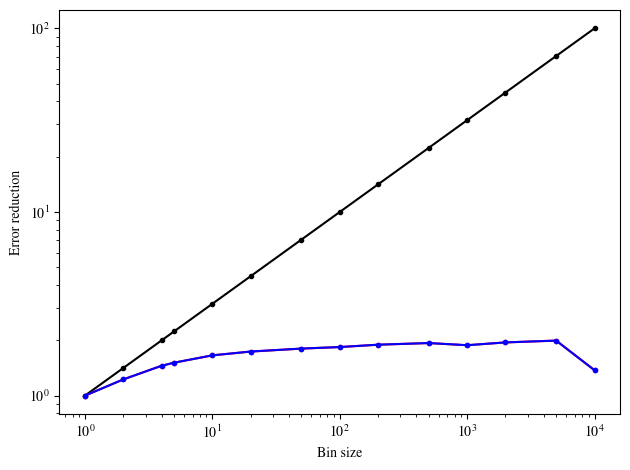

In [55]:
obs = jax.vmap(lambda x: model.observe(x, 2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [56]:
obs = [jax.vmap(lambda x: model.observe(x, i))(conf) for i in range(1, 65)]


In [35]:
[autocorr_time_fft(obs[i][::]) for i in range(64)]

[np.float32(4.5490875),
 np.float32(4.3158503),
 np.float32(4.015328),
 np.float32(3.9069724),
 np.float32(3.7080107),
 np.float32(3.4990911),
 np.float32(3.2675893),
 np.float32(3.1528141),
 np.float32(2.9928405),
 np.float32(2.8141723),
 np.float32(2.6486497),
 np.float32(2.5013378),
 np.float32(2.370727),
 np.float32(2.2503736),
 np.float32(2.1436906),
 np.float32(2.0414116),
 np.float32(1.9573791),
 np.float32(1.8849965),
 np.float32(1.8094513),
 np.float32(1.73427),
 np.float32(1.672256),
 np.float32(1.6147238),
 np.float32(1.5660256),
 np.float32(1.510812),
 np.float32(1.4754348),
 np.float32(1.4397929),
 np.float32(1.3969703),
 np.float32(1.3632361),
 np.float32(1.325365),
 np.float32(1.3032556),
 np.float32(1.273479),
 np.float32(1.2436756),
 np.float32(1.2314415),
 np.float32(1.2186866),
 np.float32(1.193691),
 np.float32(1.1832706),
 np.float32(1.171962),
 np.float32(1.1590414),
 np.float32(1.1515106),
 np.float32(1.1517625),
 np.float32(1.1336298),
 np.float32(1.1282003),
 n

In [ ]:
%timeit jackknife(obs[0], Bs=100)

941 ms ± 702 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [57]:
jac = [[i+1, jackknife(obs[i][::200], Bs=10)] for i in range(len(obs))]
l = np.array([jac[i][1] for i in range(len(jac))])

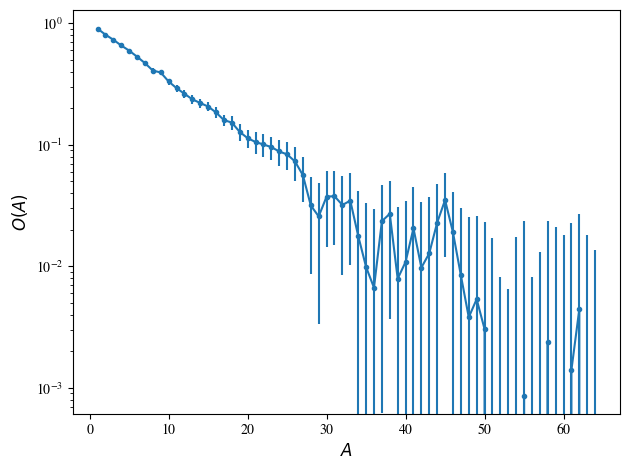

In [58]:
plt.errorbar(np.arange(1,65), l[:,0].real, l[:,1].real, marker='.') #color='black', marker='.')
#plt.plot(np.arange(1,65), np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
#plt.plot(np.arange(1,65), np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
#plt.xscale('log')
plt.yscale('log')

plt.xlabel('$A$', fontsize=12)
plt.ylabel('$ O(A) $', fontsize=12)
plt.tight_layout()
#plt.legend()
plt.show()

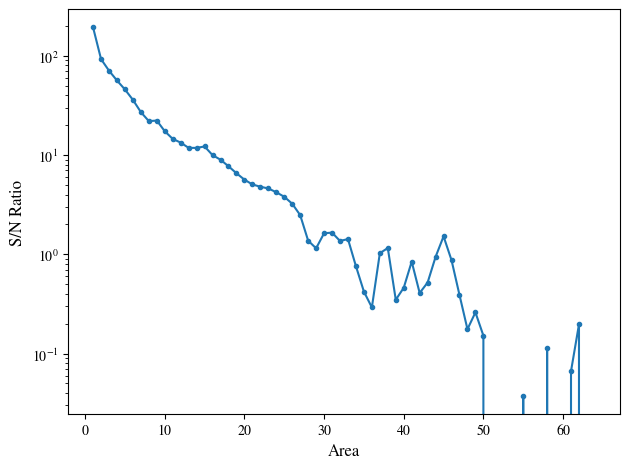

In [59]:
plt.plot(np.arange(1,65), l[:,0].real/l[:,1].real, marker='.')
#plt.plot(np.arange(1,65), np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
#plt.plot(np.arange(1,65), np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
#plt.xscale('log')
plt.yscale('log')

plt.xlabel('Area', fontsize=12)
plt.ylabel('S/N Ratio', fontsize=12)
plt.tight_layout()
#plt.legend()
plt.show()

# Comment 2

## 4D

jack bin size 1: (np.float32(0.00025539254), np.complex128(4.718593323692371e-06+0j))
bin size 1: (np.float32(0.00025539254), np.complex128(4.718579794237548e-06+0j))
jack bin size 2: (np.float32(0.00025539254), np.complex128(6.615375763015728e-06+0j))
bin size 2: (np.float32(0.00025539254), np.complex128(6.61536614929218e-06+0j))
jack bin size 4: (np.float32(0.00025539254), np.complex128(9.241301779884126e-06+0j))
bin size 4: (np.float32(0.00025539254), np.complex128(9.24131772201583e-06+0j))
jack bin size 5: (np.float32(0.00025539254), np.complex128(1.0277893851934e-05+0j))
bin size 5: (np.float32(0.00025539254), np.complex128(1.0277895199333107e-05+0j))
jack bin size 10: (np.float32(0.00025539254), np.complex128(1.4172217279952888e-05+0j))
bin size 10: (np.float32(0.00025539254), np.complex128(1.4172204195933168e-05+0j))
jack bin size 20: (np.float32(0.00025539254), np.complex128(1.919282600317804e-05+0j))
bin size 20: (np.float32(0.00025539254), np.complex128(1.9192833243309523e-05

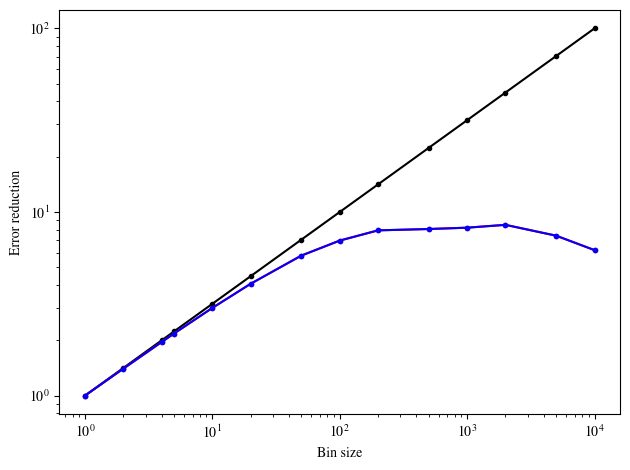

In [87]:
with open("../../scalar4d/config/c_16x8x8x8_0.1_0.5_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

# Correctly reshape Eigen column-major layout
# conf = data.reshape((m, n), order='F').T

model =  eval("scalar.Model(geom=(16, 8,8,8), m2=0.1, lamda=0.5)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

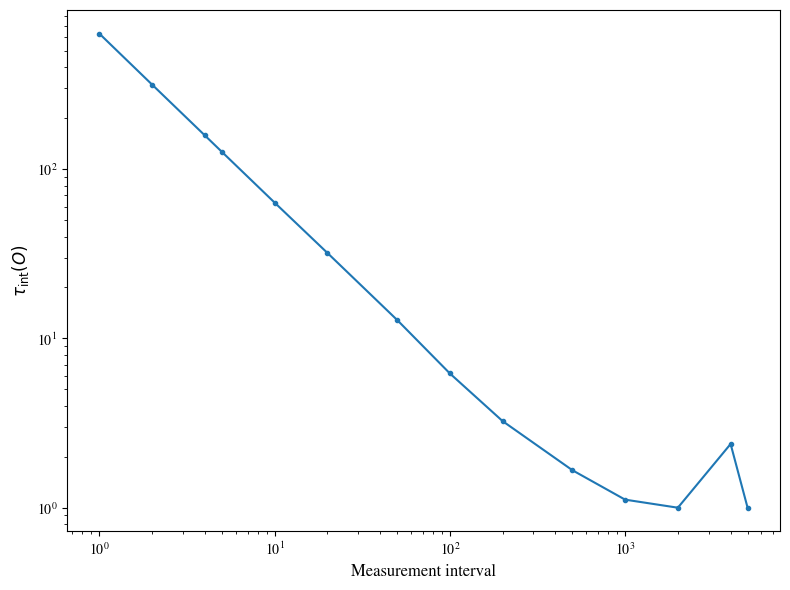

In [39]:
x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 4000, 5000])

test = [autocorr_time_fft(obs[:100000:i]) for i in x_axis]

plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
plt.plot(x_axis, test, marker='.', linestyle='-')#, label='${\\rm err}_{b=1}/{\\rm err}_{b}$')
#plt.plot(x_axis, np.sqrt(x_axis),  label='$\sqrt{x}$')#, marker='.', linestyle='-')
# plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Measurement interval', fontsize=12)
plt.ylabel('$\\tau_{\\rm int}(O)$', fontsize=12)
plt.tight_layout()
# plt.legend(loc='best')
plt.show()

In [40]:
obs = [jax.vmap(lambda x: model.observe(x, i))(conf) for i in range(0, model.shape[0]//2+1)]


jac = [[i, jackknife(obs[i][::2000], Bs=10)] for i in range(len(obs))]
l = np.array([jac[i][1] for i in range(len(jac))])

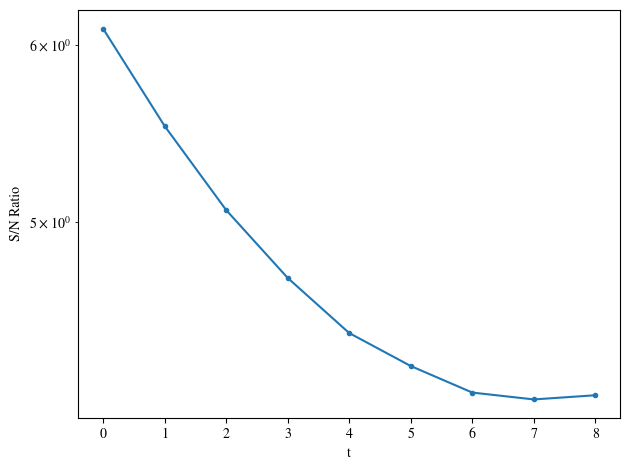

In [41]:
plt.plot(np.arange(0, model.shape[0]//2+1), l[:,0].real/l[:,1].real, marker='.')
#plt.plot(np.arange(1,65), np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
#plt.plot(np.arange(1,65), np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
#plt.xscale('log')
plt.yscale('log')

plt.xlabel('t')
plt.ylabel('S/N Ratio')
plt.tight_layout()
#plt.legend()
plt.show()

## 3D

jack bin size 1: (np.float32(0.0065089245), np.complex128(9.908135920095921e-05+0j))
bin size 1: (np.float32(0.0065089245), np.complex128(9.908318544782935e-05+0j))
jack bin size 2: (np.float32(0.0065089245), np.complex128(0.00013985395912572598+0j))
bin size 2: (np.float32(0.0065089245), np.complex128(0.00013985509071961098+0j))
jack bin size 4: (np.float32(0.0065089245), np.complex128(0.0001972372453993503+0j))
bin size 4: (np.float32(0.0065089245), np.complex128(0.0001972376246166751+0j))
jack bin size 5: (np.float32(0.0065089245), np.complex128(0.0002202380483499643+0j))
bin size 5: (np.float32(0.0065089245), np.complex128(0.00022023852871520623+0j))
jack bin size 10: (np.float32(0.0065089245), np.complex128(0.0003096372222325001+0j))
bin size 10: (np.float32(0.0065089245), np.complex128(0.00030963585140537486+0j))
jack bin size 20: (np.float32(0.0065089245), np.complex128(0.0004331073229980462+0j))
bin size 20: (np.float32(0.0065089245), np.complex128(0.00043310676476143836+0j))
j

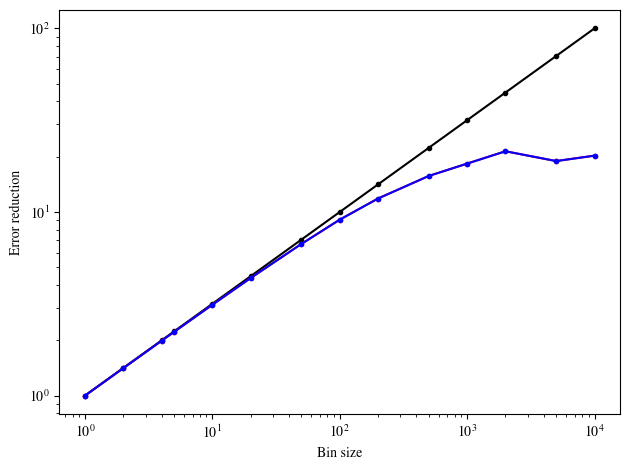

In [56]:
with open("../../scalar3d/config/c_32x8x8_0.01_0.1_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

# Correctly reshape Eigen column-major layout
# conf = data.reshape((m, n), order='F').T

model =  eval("scalar.Model(geom=(32,8,8), m2=0.01, lamda=0.1)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

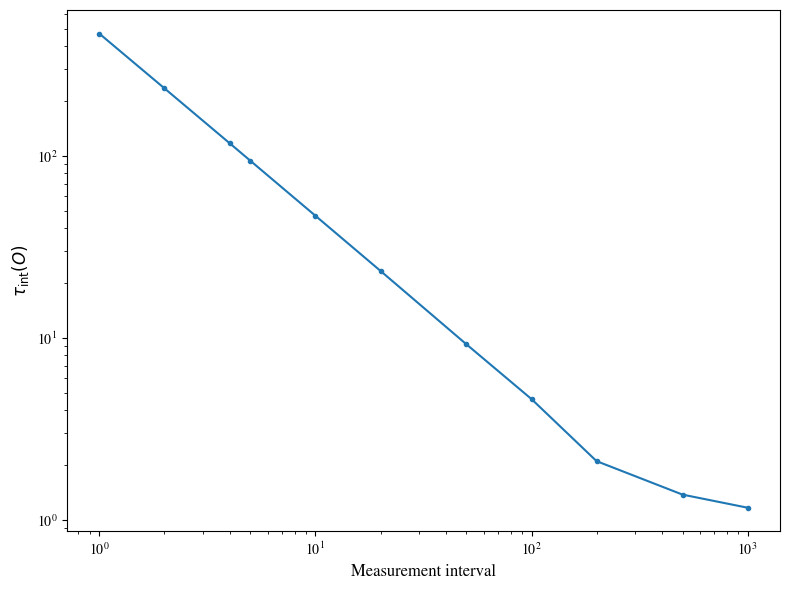

In [57]:
x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000])

test = [autocorr_time_fft(obs[:100000:i]) for i in x_axis]

plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
plt.plot(x_axis, test, marker='.', linestyle='-')#, label='${\\rm err}_{b=1}/{\\rm err}_{b}$')
#plt.plot(x_axis, np.sqrt(x_axis),  label='$\sqrt{x}$')#, marker='.', linestyle='-')
# plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Measurement interval', fontsize=12)
plt.ylabel('$\\tau_{\\rm int}(O)$', fontsize=12)
plt.tight_layout()
# plt.legend(loc='best')
plt.show()

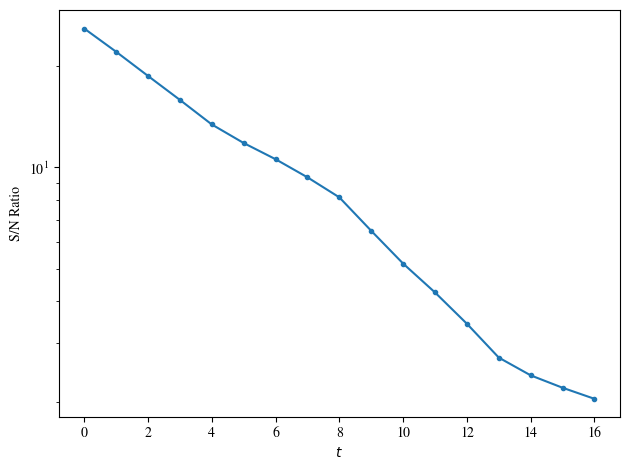

In [58]:
obs = [jax.vmap(lambda x: model.observe(x, i))(conf) for i in range(0, model.shape[0]//2+1)]

jac = [[i, jackknife(obs[i][::1000], Bs=10)] for i in range(len(obs))]
l = np.array([jac[i][1] for i in range(len(jac))])

plt.plot(np.arange(0, model.shape[0]//2+1), l[:,0].real/l[:,1].real, marker='.')
#plt.plot(np.arange(1,65), np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
#plt.plot(np.arange(1,65), np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
#plt.xscale('log')
plt.yscale('log')

plt.xlabel('$t$')
plt.ylabel('S/N Ratio')
plt.tight_layout()
#plt.legend()
plt.show()

In [59]:
l[:,0].real/l[:,1].real

array([25.9087277 , 22.09866256, 18.72265251, 15.88801309, 13.42785897,
       11.82337062, 10.58142688,  9.34684491,  8.14749648,  6.47840508,
        5.17573525,  4.24654541,  3.42705279,  2.7175263 ,  2.4063969 ,
        2.21043616,  2.04898362])

## 2D

In [48]:
conf.shape

(200000, 8192)

jack bin size 1: (np.float32(0.0035599817), np.complex128(0.00011990010885560842+0j))
bin size 1: (np.float32(0.0035599817), np.complex128(0.00011990134551381811+0j))
jack bin size 2: (np.float32(0.0035599817), np.complex128(0.00016616923800916614+0j))
bin size 2: (np.float32(0.0035599817), np.complex128(0.00016616854843756865+0j))
jack bin size 4: (np.float32(0.0035599817), np.complex128(0.00022852820528731658+0j))
bin size 4: (np.float32(0.0035599817), np.complex128(0.0002285271755981584+0j))
jack bin size 5: (np.float32(0.0035599817), np.complex128(0.000252333894924349+0j))
bin size 5: (np.float32(0.0035599817), np.complex128(0.0002523335635520957+0j))
jack bin size 10: (np.float32(0.0035599817), np.complex128(0.0003383680647163182+0j))
bin size 10: (np.float32(0.0035599817), np.complex128(0.0003383683100943418+0j))
jack bin size 20: (np.float32(0.0035599817), np.complex128(0.0004391619184387924+0j))
bin size 20: (np.float32(0.0035599817), np.complex128(0.00043916189680241264+0j))
j

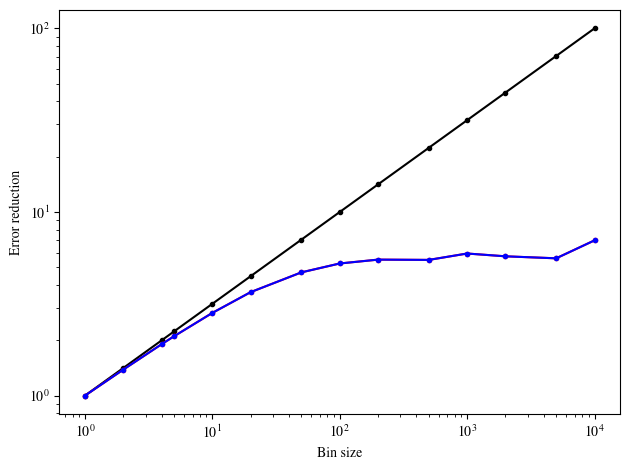

In [50]:
with open("../../1+1scalar/config/c_16x16_0.1_0.5_sweep1.pkl", "rb") as aa:
    conf = pickle.load(aa)


model =  eval("scalar.Model(geom=(16,16), m2=0.1, lamda=0.5)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

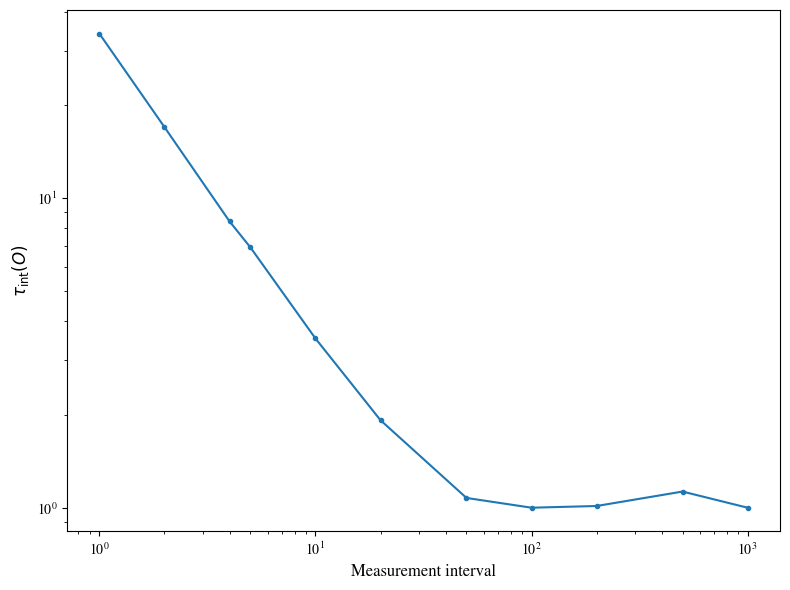

In [51]:
x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000])

test = [autocorr_time_fft(obs[:100000:i]) for i in x_axis]

plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
plt.plot(x_axis, test, marker='.', linestyle='-')#, label='${\\rm err}_{b=1}/{\\rm err}_{b}$')
#plt.plot(x_axis, np.sqrt(x_axis),  label='$\sqrt{x}$')#, marker='.', linestyle='-')
# plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Measurement interval', fontsize=12)
plt.ylabel('$\\tau_{\\rm int}(O)$', fontsize=12)
plt.tight_layout()
# plt.legend(loc='best')
plt.show()

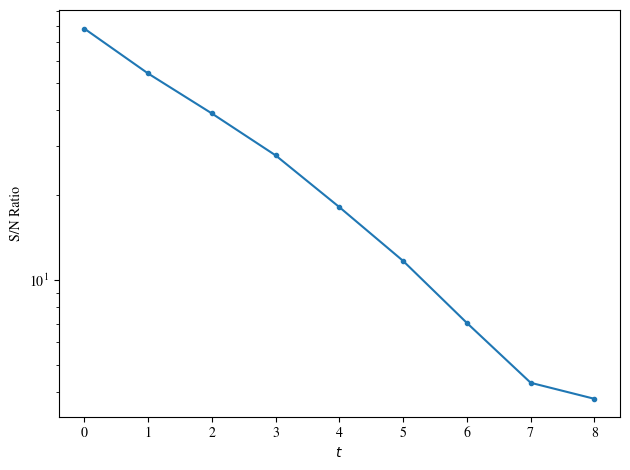

In [52]:
obs = [jax.vmap(lambda x: model.observe(x, i))(conf) for i in range(0, model.shape[0]//2+1)]

jac = [[i, jackknife(obs[i][::100], Bs=10)] for i in range(len(obs))]
l = np.array([jac[i][1] for i in range(len(jac))])

plt.plot(np.arange(0, model.shape[0]//2+1), l[:,0].real/l[:,1].real, marker='.')
#plt.plot(np.arange(1,65), np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
#plt.plot(np.arange(1,65), np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
#plt.xscale('log')
plt.yscale('log')

plt.xlabel('$t$')
plt.ylabel('S/N Ratio')
plt.tight_layout()
#plt.legend()
plt.show()

In [53]:
l[:,0].real/l[:,1].real

array([78.16883457, 54.14559817, 39.03969175, 27.70268087, 18.13881664,
       11.67958068,  7.03153406,  4.3104042 ,  3.78060296])

# Comment 3 + 4

## Scalar

In [2]:
class MLP(nn.Module):
    volume: int
    features: Sequence[int]
    kernel_init: Callable = nn.initializers.variance_scaling(
        2, "fan_in", "truncated_normal")  # for ReLU / CELU
    bias_init: Callable = nn.initializers.zeros

    @nn.compact
    def __call__(self, x):
        for feat in self.features:
            x = nn.Dense(feat, use_bias=False,
                         kernel_init=self.kernel_init,
                         bias_init=self.bias_init)(x)
            x = arcsinh(x)
        x = nn.Dense(1, use_bias=False,
                     kernel_init=self.bias_init)(x)
        return x


class CV_MLP(nn.Module):
    volume: int
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = MLP(self.volume, self.features)(x)
        y = self.param('bias', nn.initializers.zeros, (1,))
        return x, y


### 2D

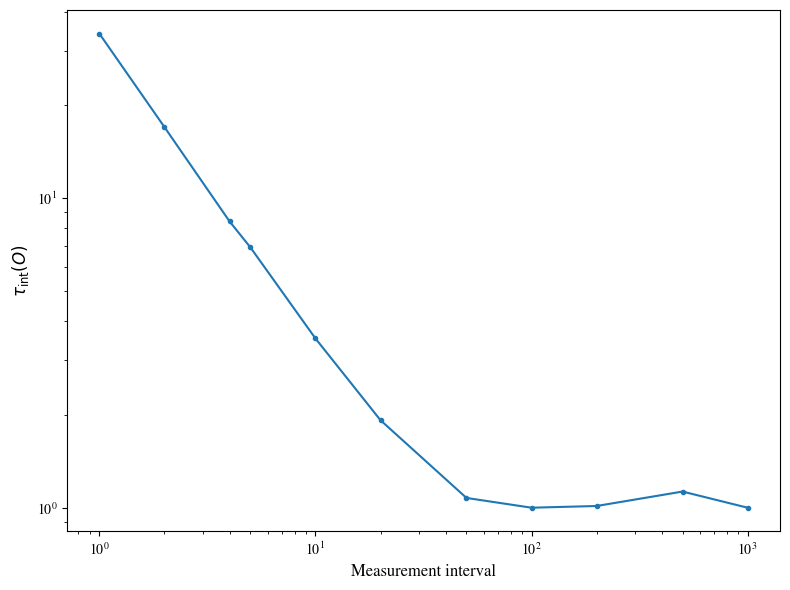

In [5]:
with open("../../1+1scalar/config/c_16x16_0.1_0.5_sweep1.pkl", "rb") as aa:
    conf = pickle.load(aa)


model =  eval("scalar.Model(geom=(16,16), m2=0.1, lamda=0.5)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000])

test = [autocorr_time_fft(obs[:100000:i]) for i in x_axis]

plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
plt.plot(x_axis, test, marker='.', linestyle='-')#, label='${\\rm err}_{b=1}/{\\rm err}_{b}$')
#plt.plot(x_axis, np.sqrt(x_axis),  label='$\sqrt{x}$')#, marker='.', linestyle='-')
# plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Measurement interval', fontsize=12)
plt.ylabel('$\\tau_{\\rm int}(O)$', fontsize=12)
plt.tight_layout()
# plt.legend(loc='best')
plt.show()

In [7]:
[autocorr_time_fft(obs[:100000:i]) for i in [1,2,4,8,16]]

[np.float32(34.02166),
 np.float32(16.977705),
 np.float32(8.421924),
 np.float32(4.2797494),
 np.float32(2.25535)]

In [8]:
[autocorr_time_fft(obs[:100000:i]) for i in [80]]

[np.float32(1.0223458)]

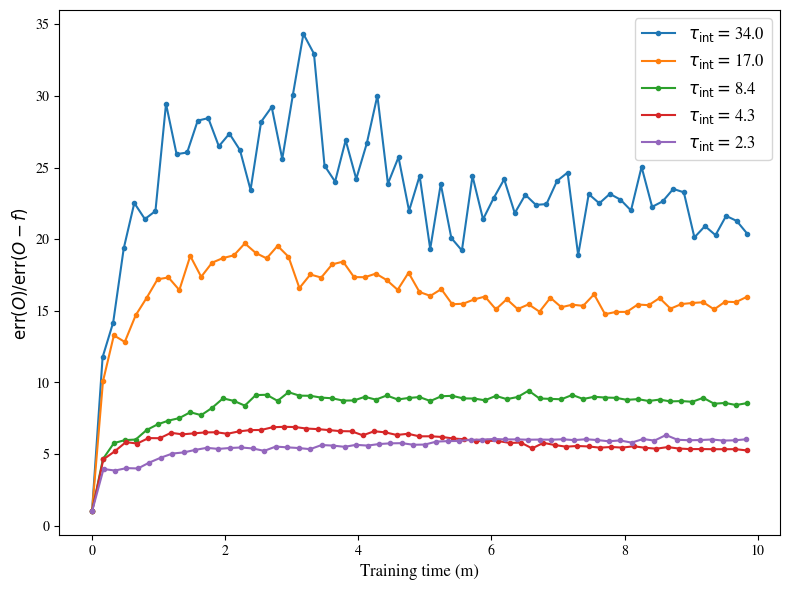

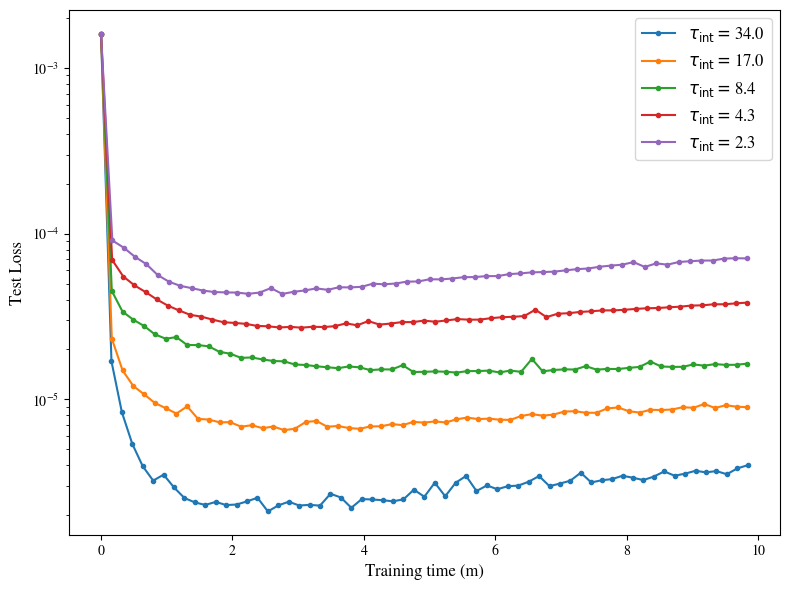

1: (34.3240819294631+0j)
2: (19.705244743080645+0j)
4: (9.429180145968058+0j)
8: (6.905078976815836+0j)
16: (6.332729807327411+0j)
1: 2.1077521523693576e-06
2: 6.522116564156022e-06
4: 1.4499386452371255e-05
8: 2.7063109882874414e-05
16: 4.3229640141362324e-05


In [9]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("scalar2d/cv_16x16_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_10min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


autocorr = [autocorr_time_fft(obs[:100000:i]) for i in [1,2,4,8,16]]

plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_red[i]))/len(track_red[i])*10, np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'$\\tau_{{\\rm int}}=${autocorr[i]:.1f}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('${\\rm err}(O) / {\\rm err}(O-f)  $ ', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()



plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_ltest[i]))/len(track_red[i])*10, np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'$\\tau_{{\\rm int}}=${autocorr[i]:.1f}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('Test Loss', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

In [10]:
[autocorr_time_fft(obs[:100000:i]) for i in [80]]

[np.float32(1.0223458)]

In [11]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array(
    [(-i, -j) for i, j in product(*list(map(lambda y: range(y), model.shape)))])


def g(x, p):
    def g_(x, p, ind):
        return g1.apply(p, jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V))[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)

dS = jax.grad(lambda y: model.action(y).real)

dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [12]:
binsize=80

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("scalar2d/cv_16x16_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.0016032276907935739 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 8000: <Test loss>: 0.0009759951499290764 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.003042222), np.complex128(0.0008918624428064266+0j)) <f>: (np.float32(0.00026792515), np.complex128(0.0009945906497998804+0j))
Epoch 16000: <Test loss>: 0.000918792502488941 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0031397203), np.complex128(0.0008549103441153627+0j)) <f>: (np.float32(0.00017042657), np.complex128(0.0009860687852444434+0j))
Epoch 24000: <Test loss>: 0.0008980781421996653 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0034087463), np.complex128(0.000810574003800025+0j)) <f>: (np.float32(-9.860195e-05), n

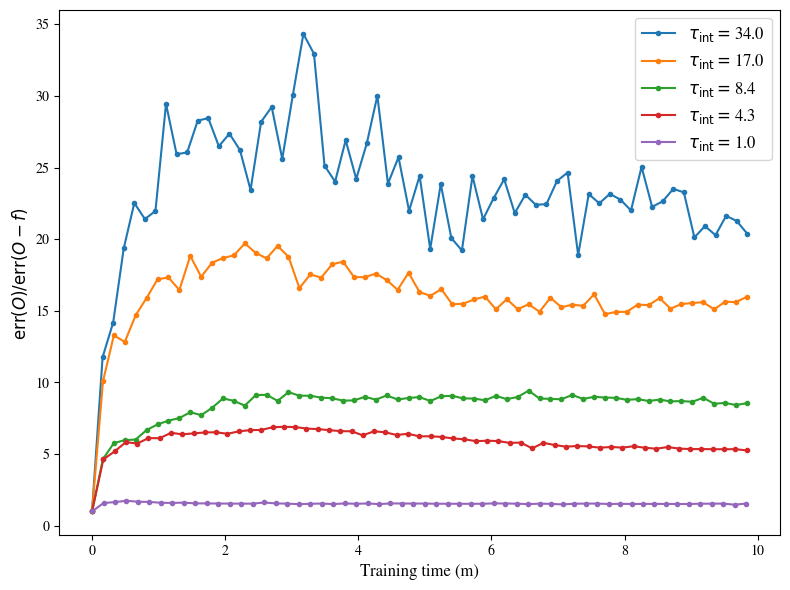

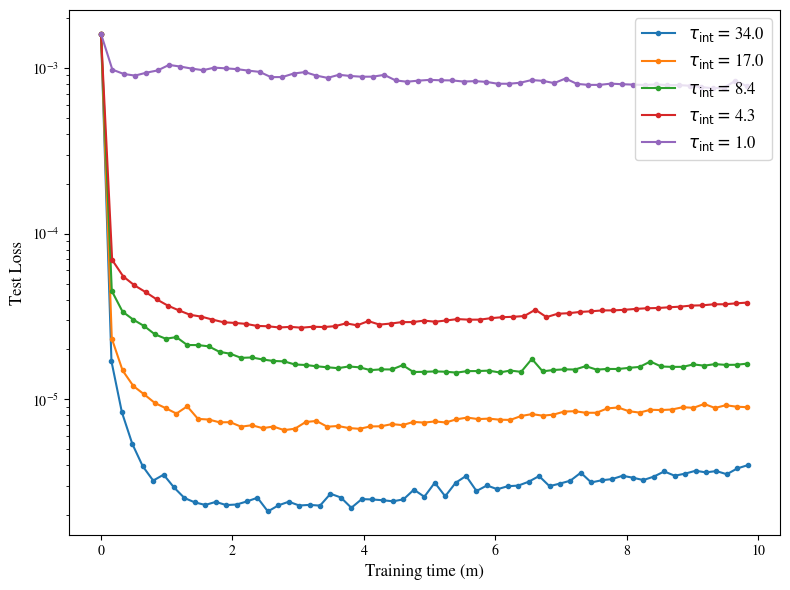

1: (34.3240819294631+0j)
2: (19.705244743080645+0j)
4: (9.429180145968058+0j)
8: (6.905078976815836+0j)
16: (1.7452609233016192+0j)
1: 2.1077521523693576e-06
2: 6.522116564156022e-06
4: 1.4499386452371255e-05
8: 2.7063109882874414e-05
16: 0.0007539133657701313


In [6]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8,  80:
    with open("scalar2d/cv_16x16_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_10min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)
autocorr = [autocorr_time_fft(obs[:100000:i]) for i in [1,2,4,8, 80]]


plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_red[i]))/len(track_red[i])*10, np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'$\\tau_{{\\rm int}}=${autocorr[i]:.1f}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('${\\rm err}(O) / {\\rm err}(O-f)  $ ', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()



plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_ltest[i]))/len(track_red[i])*10, np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'$\\tau_{{\\rm int}}=${autocorr[i]:.1f}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('Test Loss', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

### 3D

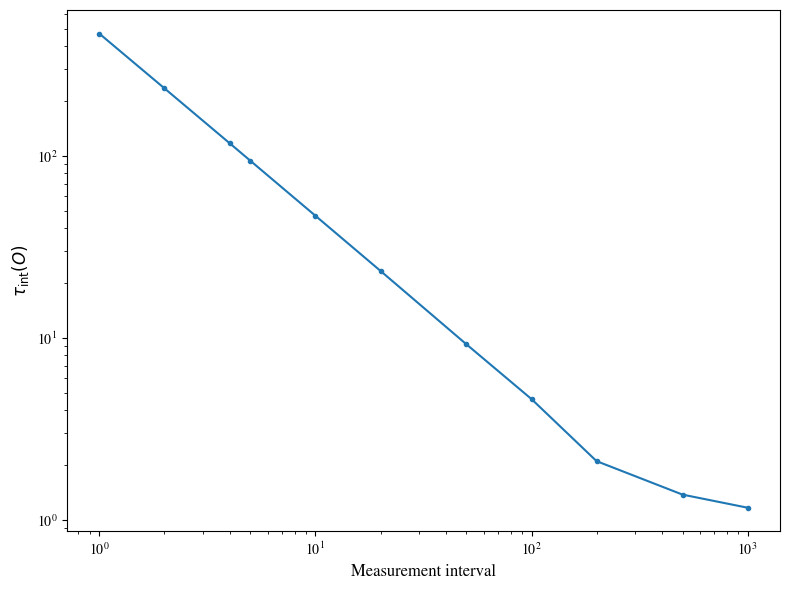

In [7]:
with open("../../scalar3d/config/c_32x8x8_0.01_0.1_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

# Correctly reshape Eigen column-major layout
# conf = data.reshape((m, n), order='F').T

model =  eval("scalar.Model(geom=(32,8,8), m2=0.01, lamda=0.1)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000])

test = [autocorr_time_fft(obs[:100000:i]) for i in x_axis]

plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
plt.plot(x_axis, test, marker='.', linestyle='-')#, label='${\\rm err}_{b=1}/{\\rm err}_{b}$')
#plt.plot(x_axis, np.sqrt(x_axis),  label='$\sqrt{x}$')#, marker='.', linestyle='-')
# plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Measurement interval', fontsize=12)
plt.ylabel('$\\tau_{\\rm int}(O)$', fontsize=12)
plt.tight_layout()
# plt.legend(loc='best')
plt.show()

In [5]:
[[i,autocorr_time_fft(obs[:200000:i])] for i in range(500, 600, 2)]

[[500, np.float32(1.2997516)],
 [502, np.float32(1.3708134)],
 [504, np.float32(1.0756645)],
 [506, np.float32(1.4061706)],
 [508, np.float32(1.3558358)],
 [510, np.float32(1.1610167)],
 [512, np.float32(1.0)],
 [514, np.float32(1.5217316)],
 [516, np.float32(1.0422361)],
 [518, np.float32(1.2043839)],
 [520, np.float32(1.1561567)],
 [522, np.float32(1.3268505)],
 [524, np.float32(1.2809323)],
 [526, np.float32(1.0386884)],
 [528, np.float32(1.0054746)],
 [530, np.float32(1.256993)],
 [532, np.float32(1.5647871)],
 [534, np.float32(1.217835)],
 [536, np.float32(1.091234)],
 [538, np.float32(1.1268871)],
 [540, np.float32(1.0914708)],
 [542, np.float32(1.236795)],
 [544, np.float32(1.1378056)],
 [546, np.float32(1.3724024)],
 [548, np.float32(1.3610511)],
 [550, np.float32(1.0498556)],
 [552, np.float32(1.236154)],
 [554, np.float32(1.2305475)],
 [556, np.float32(1.3113678)],
 [558, np.float32(1.1717068)],
 [560, np.float32(1.1672728)],
 [562, np.float32(1.2785407)],
 [564, np.float32(1

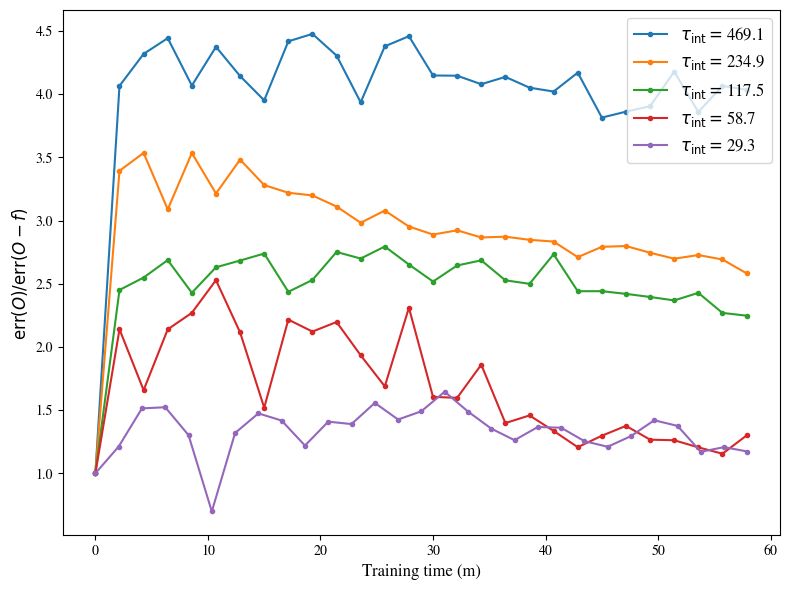

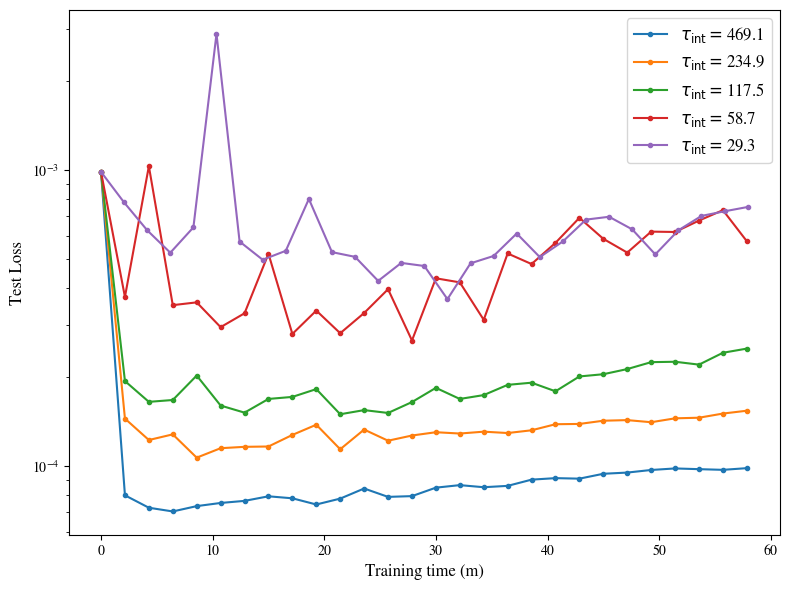

1: (4.477909008490175+0j)
2: (3.536027170765789+0j)
4: (2.7951390007295474+0j)
8: (2.528915226580454+0j)
16: (1.6460951201012637+0j)
1: 7.03048353898339e-05
2: 0.0001068311685230583
4: 0.00014973215002100915
8: 0.00026569905458018184
16: 0.0003665108233690262


In [28]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("scalar3d/cv_32x8x8_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_1h.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


autocorr = [autocorr_time_fft(obs[:100000:i]) for i in [1,2,4,8,16]]


plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_red[i]))/len(track_red[i])*60, np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'$\\tau_{{\\rm int}}=${autocorr[i]:.1f}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('${\\rm err}(O) / {\\rm err}(O-f)  $ ', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()


plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_ltest[i]))/len(track_red[i])*60, np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'$\\tau_{{\\rm int}}=${autocorr[i]:.1f}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('Test Loss', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

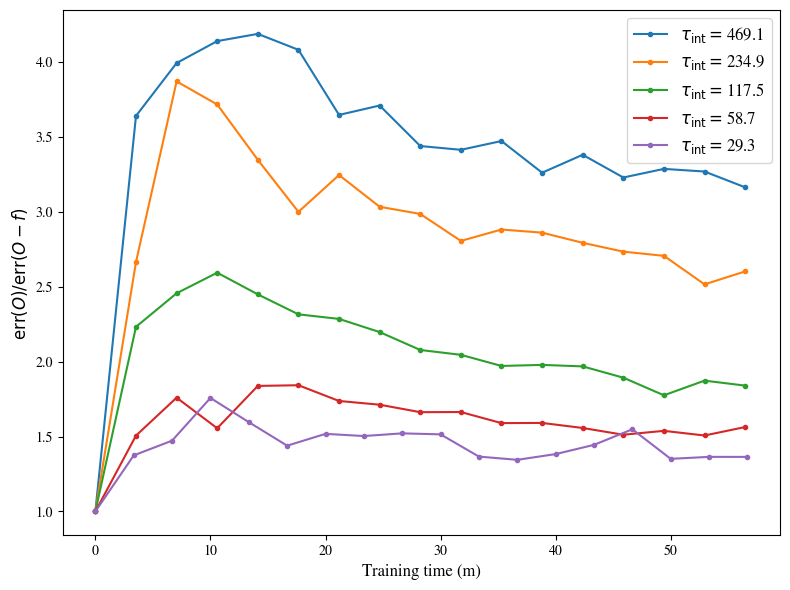

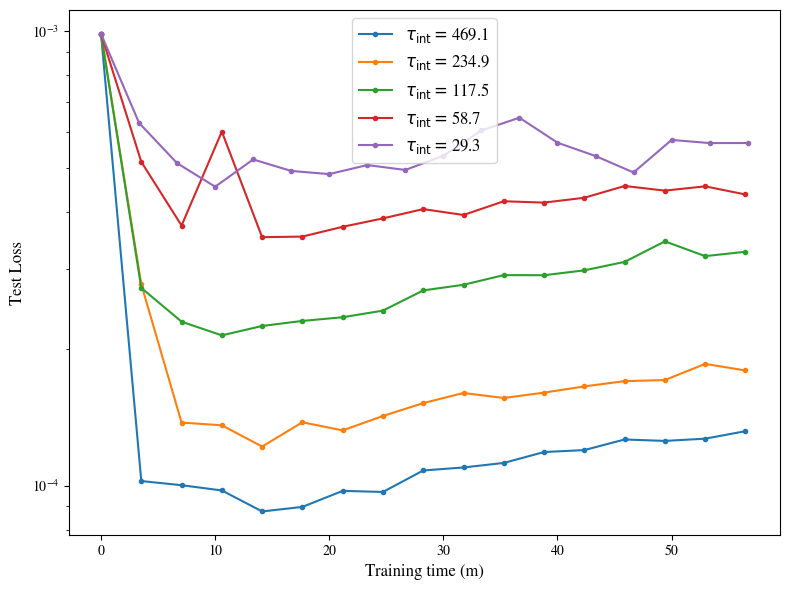

1: (4.186623077098476+0j)
2: (3.86954830995727+0j)
4: (2.5931264409434047+0j)
8: (1.8421392786906383+0j)
16: (1.7573872546349414+0j)
1: 8.772227738518268e-05
2: 0.00012185702507849783
4: 0.0002140891010640189
8: 0.00035206504981033504
16: 0.0004546348354779184


In [29]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("scalar3d/cv_32x8x8_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_1h.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


autocorr = [autocorr_time_fft(obs[:100000:i]) for i in [1,2,4,8,16]]


plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_red[i]))/len(track_red[i])*60, np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'$\\tau_{{\\rm int}}=${autocorr[i]:.1f}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('${\\rm err}(O) / {\\rm err}(O-f)  $ ', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()


plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_ltest[i]))/len(track_red[i])*60, np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'$\\tau_{{\\rm int}}=${autocorr[i]:.1f}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('Test Loss', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

In [38]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [39]:
binsize=500

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32 if n_train>=32 else n_train
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("scalar3d/cv_32x8x8_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_1h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.0009862387087196112 <O>: (np.float32(0.005961247), np.complex128(0.0015081992718695844+0j)) <O-f>: (np.float32(0.005961247), np.complex128(0.0015081992718695844+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 50000: <Test loss>: 0.0015698358183726668 <O>: (np.float32(0.005961247), np.complex128(0.0015081992718695844+0j)) <O-f>: (np.float32(0.0065017156), np.complex128(0.001409854354256398+0j)) <f>: (np.float32(-0.0005404689), np.complex128(0.0007997260222592737+0j))
Epoch 100000: <Test loss>: 0.0013283396838232875 <O>: (np.float32(0.005961247), np.complex128(0.0015081992718695844+0j)) <O-f>: (np.float32(0.005940711), np.complex128(0.001779293516044026+0j)) <f>: (np.float32(2.0541407e-05), np.complex128(0.0005042684111386663+0j))
Epoch 150000: <Test loss>: 0.002256547100841999 <O>: (np.float32(0.005961247), np.complex128(0.0015081992718695844+0j)) <O-f>: (np.float32(0.0053231157), np.complex128(0.001502515533906395+0j)) <f>: (np.float32(0.00063813507), np.co

In [6]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [64]*4)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [7]:
binsize=500

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32 if n_train>=32 else n_train
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("scalar3d/cv_32x8x8_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_1h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.0009862387087196112 <O>: (np.float32(0.005961247), np.complex128(0.0015081992718695844+0j)) <O-f>: (np.float32(0.005961247), np.complex128(0.0015081992718695844+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 50000: <Test loss>: 0.0011508245952427387 <O>: (np.float32(0.005961247), np.complex128(0.0015081992718695844+0j)) <O-f>: (np.float32(0.006466327), np.complex128(0.001630976917492512+0j)) <f>: (np.float32(-0.0005050797), np.complex128(0.00045565604212756617+0j))
Epoch 100000: <Test loss>: 0.0009257843485102057 <O>: (np.float32(0.005961247), np.complex128(0.0015081992718695844+0j)) <O-f>: (np.float32(0.0072114393), np.complex128(0.0014191945969025995+0j)) <f>: (np.float32(-0.0012501872), np.complex128(0.000478580206648495+0j))
Epoch 150000: <Test loss>: 0.0011188288917765021 <O>: (np.float32(0.005961247), np.complex128(0.0015081992718695844+0j)) <O-f>: (np.float32(0.007107232), np.complex128(0.0016609312555472908+0j)) <f>: (np.float32(-0.0011459873), np.

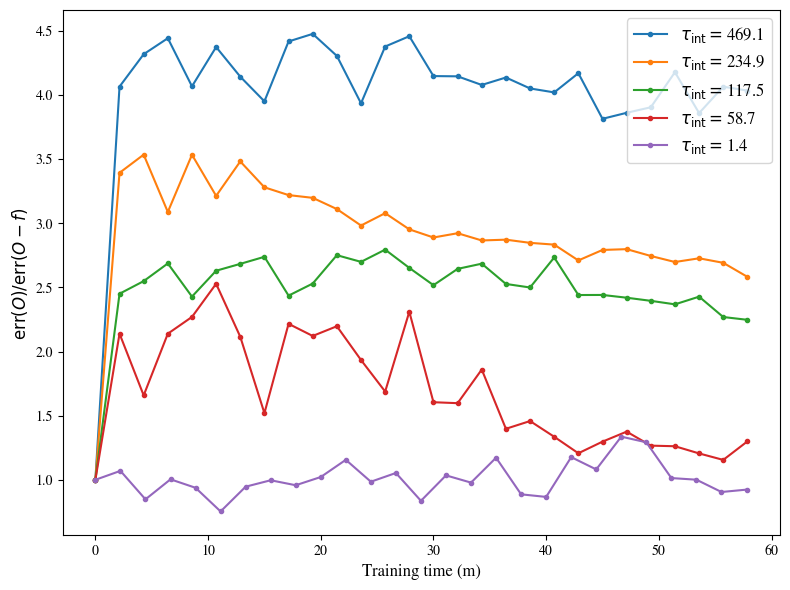

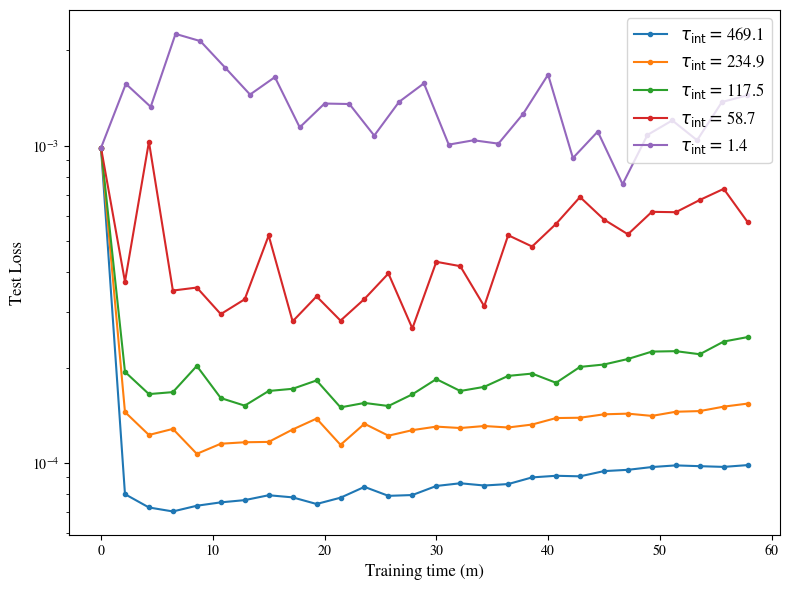

1: (4.477909008490175+0j)
2: (3.536027170765789+0j)
4: (2.7951390007295474+0j)
8: (2.528915226580454+0j)
16: (1.336531297944034+0j)
1: 7.03048353898339e-05
2: 0.0001068311685230583
4: 0.00014973215002100915
8: 0.00026569905458018184
16: 0.0007570309680886567


In [8]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8,  500:
    with open("scalar3d/cv_32x8x8_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_1h.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)
autocorr = [autocorr_time_fft(obs[:100000:i]) for i in [1,2,4,8, 500]]


plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_red[i]))/len(track_red[i])*60, np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'$\\tau_{{\\rm int}}=${autocorr[i]:.1f}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('${\\rm err}(O) / {\\rm err}(O-f)  $ ', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()


plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_ltest[i]))/len(track_red[i])*60, np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'$\\tau_{{\\rm int}}=${autocorr[i]:.1f}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('Test Loss', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

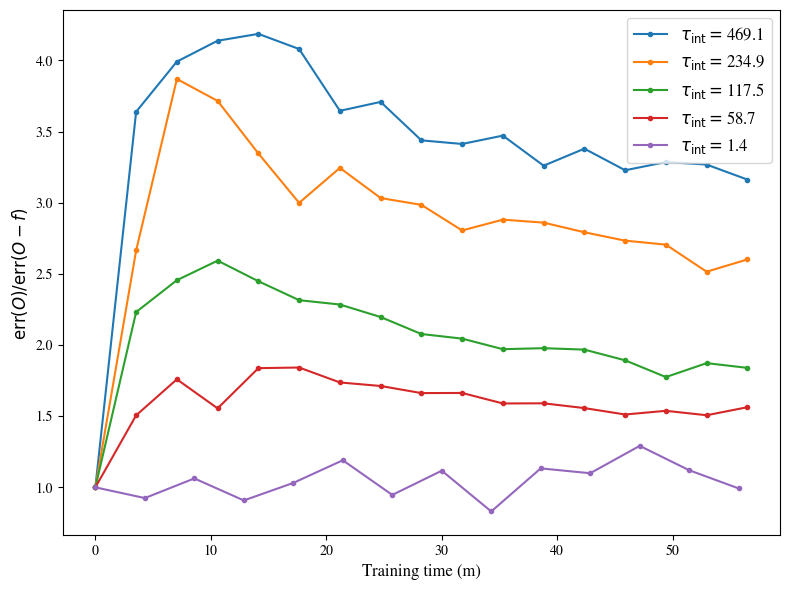

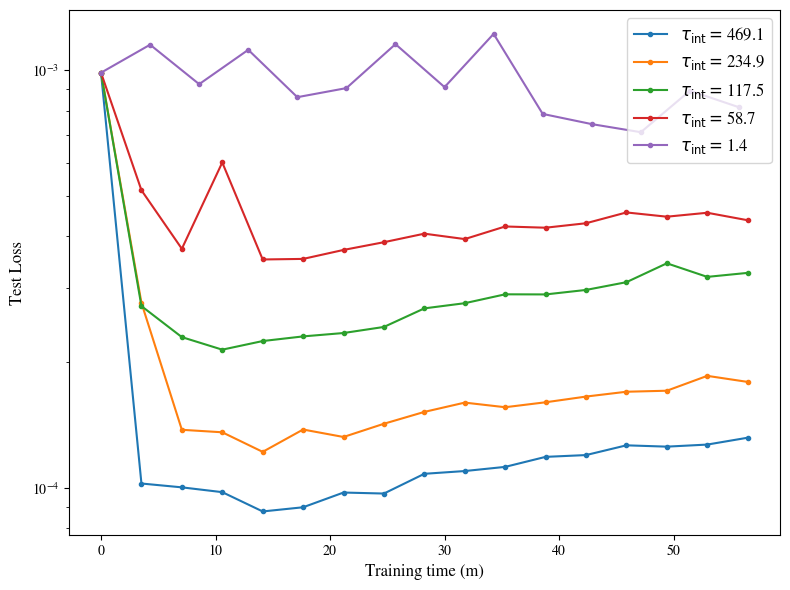

1: (4.186623077098476+0j)
2: (3.86954830995727+0j)
4: (2.5931264409434047+0j)
8: (1.8421392786906383+0j)
16: (1.2915842765756183+0j)
1: 8.772227738518268e-05
2: 0.00012185702507849783
4: 0.0002140891010640189
8: 0.00035206504981033504
16: 0.0007103029638528824


In [9]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8,  500:
    with open("scalar3d/cv_32x8x8_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_1h.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)
autocorr = [autocorr_time_fft(obs[:100000:i]) for i in [1,2,4,8, 500]]


plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_red[i]))/len(track_red[i])*60, np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'$\\tau_{{\\rm int}}=${autocorr[i]:.1f}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('${\\rm err}(O) / {\\rm err}(O-f)  $ ', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()


plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_ltest[i]))/len(track_red[i])*60, np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'$\\tau_{{\\rm int}}=${autocorr[i]:.1f}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('Test Loss', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

### 4D

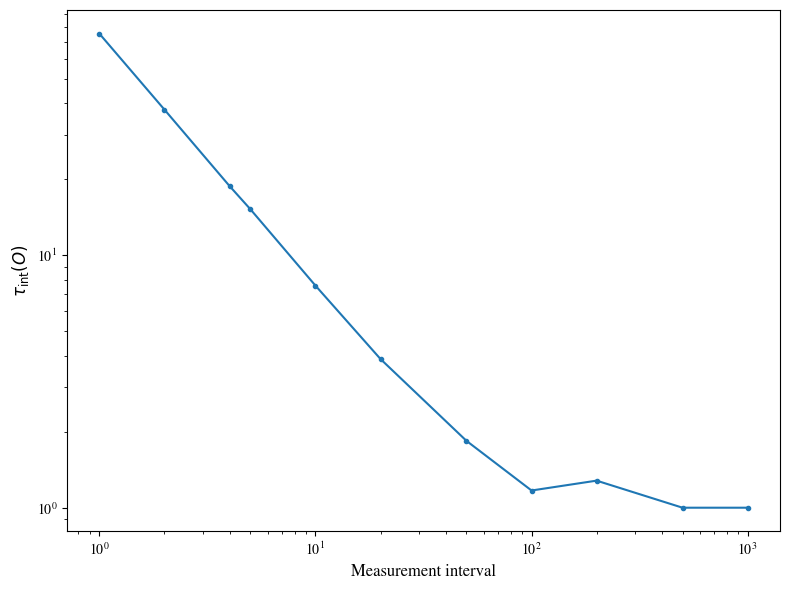

In [10]:
with open("../../scalar4d/config/c_16x8x8x8_0.1_0.5_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

# Correctly reshape Eigen column-major layout
# conf = data.reshape((m, n), order='F').T

model =  eval("scalar.Model(geom=(16, 8,8,8), m2=0.1, lamda=0.5)")
V=model.dof

# obs = jax.lax.map(lambda x: model.observe(x, model.shape[0]//2), conf, Bs=1e4)
obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000])

test = [autocorr_time_fft(obs[:100000:i]) for i in x_axis]

plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
plt.plot(x_axis, test, marker='.', linestyle='-')#, label='${\\rm err}_{b=1}/{\\rm err}_{b}$')
#plt.plot(x_axis, np.sqrt(x_axis),  label='$\sqrt{x}$')#, marker='.', linestyle='-')
# plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Measurement interval', fontsize=12)
plt.ylabel('$\\tau_{\\rm int}(O)$', fontsize=12)
plt.tight_layout()
# plt.legend(loc='best')
plt.show()

In [10]:
[[i,autocorr_time_fft(obs[:100000:i])] for i in range(50, 250, 5)]

[[50, np.float32(1.8392724)],
 [55, np.float32(1.6030167)],
 [60, np.float32(1.6023898)],
 [65, np.float32(1.4210981)],
 [70, np.float32(1.4757055)],
 [75, np.float32(1.3871562)],
 [80, np.float32(1.3484482)],
 [85, np.float32(1.3326699)],
 [90, np.float32(1.2215136)],
 [95, np.float32(1.2736586)],
 [100, np.float32(1.1698463)],
 [105, np.float32(1.1048461)],
 [110, np.float32(1.064026)],
 [115, np.float32(1.0590762)],
 [120, np.float32(1.0956769)],
 [125, np.float32(1.0889378)],
 [130, np.float32(1.0448341)],
 [135, np.float32(1.1153098)],
 [140, np.float32(1.1416785)],
 [145, np.float32(1.104344)],
 [150, np.float32(1.038771)],
 [155, np.float32(1.089207)],
 [160, np.float32(1.035233)],
 [165, np.float32(1.0335944)],
 [170, np.float32(1.0)],
 [175, np.float32(1.0)],
 [180, np.float32(1.0)],
 [185, np.float32(1.0)],
 [190, np.float32(1.0)],
 [195, np.float32(1.0)],
 [200, np.float32(1.2798841)],
 [205, np.float32(1.0)],
 [210, np.float32(1.0886334)],
 [215, np.float32(1.0)],
 [220, np

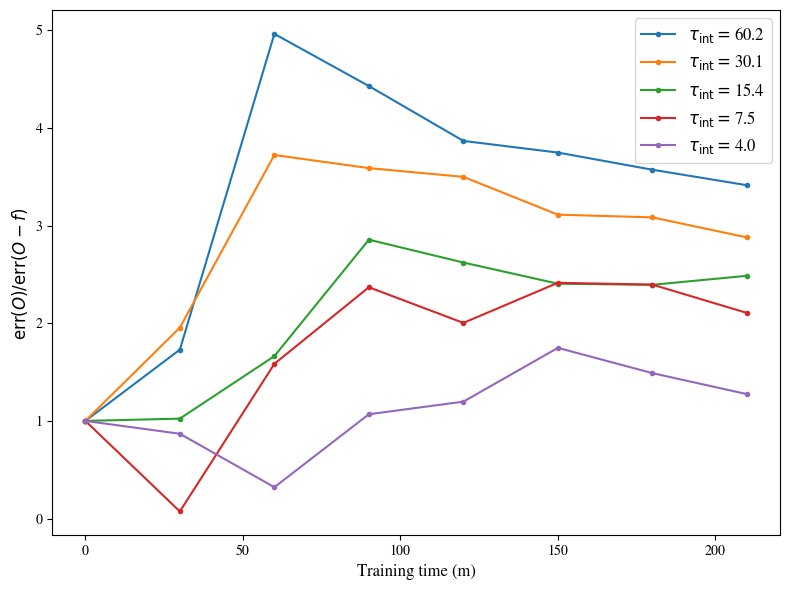

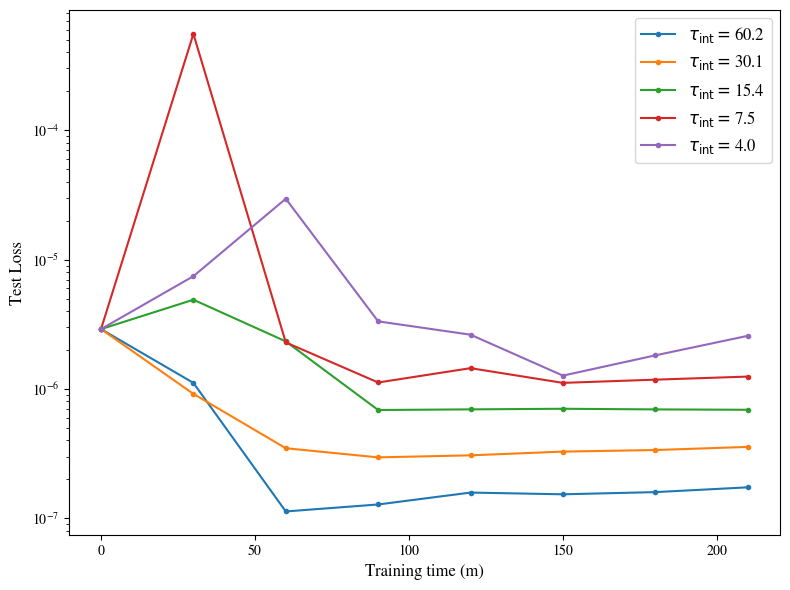

1: (4.962025895341692+0j)
2: (3.7221234500050286+0j)
4: (2.85526632381374+0j)
8: (2.4138193789261853+0j)
16: (1.7477883742165221+0j)
1: 1.1301762015136774e-07
2: 2.959196194751712e-07
4: 6.875184226373676e-07
8: 1.1142010407638736e-06
16: 1.2679042811214458e-06


In [86]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("scalar4d/cv_16x8x8x8_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_4h.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)

autocorr = [autocorr_time_fft(obs[:10000:i]) for i in [1,2,4,8,16]]


plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_red[i]))/len(track_red[i])*240, np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'$\\tau_{{\\rm int}}=${autocorr[i]:.1f}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('${\\rm err}(O) / {\\rm err}(O-f)  $ ', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()


plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_ltest[i]))/len(track_red[i])*240, np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'$\\tau_{{\\rm int}}=${autocorr[i]:.1f}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('Test Loss', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

In [11]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [12]:
binsize=125

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("scalar4d/cv_16x8x8x8_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_4h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 2.9021271075180266e-06 <O>: (np.float32(0.00034363184), np.complex128(6.151087465555962e-05+0j)) <O-f>: (np.float32(0.00034363184), np.complex128(6.151087465555962e-05+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 12500: <Test loss>: 5.8893378991342615e-06 <O>: (np.float32(0.00034363184), np.complex128(6.151087465555962e-05+0j)) <O-f>: (np.float32(0.00034939923), np.complex128(7.568921402636866e-05+0j)) <f>: (np.float32(-5.7676784e-06), np.complex128(6.298468228906995e-05+0j))
Epoch 25000: <Test loss>: 8.003780749277212e-06 <O>: (np.float32(0.00034363184), np.complex128(6.151087465555962e-05+0j)) <O-f>: (np.float32(0.00029467893), np.complex128(9.68377575203791e-05+0j)) <f>: (np.float32(4.8952545e-05), np.complex128(0.00010830669025625838+0j))
Epoch 37500: <Test loss>: 9.644622878113296e-06 <O>: (np.float32(0.00034363184), np.complex128(6.151087465555962e-05+0j)) <O-f>: (np.float32(0.00025126163), np.complex128(8.78628339190153e-05+0j)) <f>: (np.float32(9.2

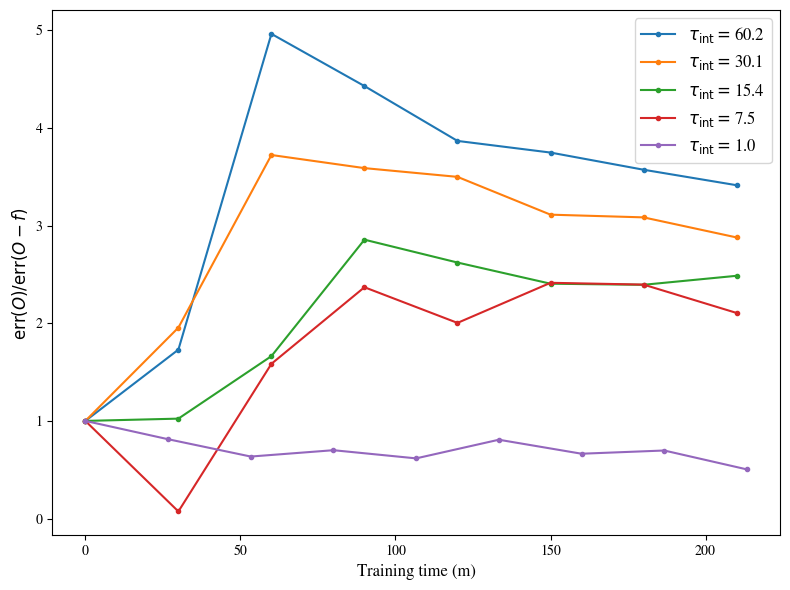

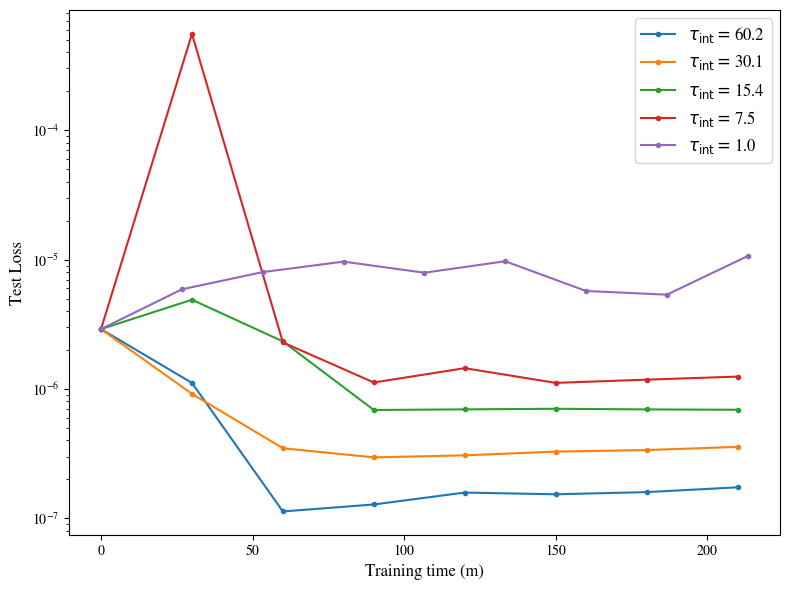

1: (4.962025895341692+0j)
2: (3.7221234500050286+0j)
4: (2.85526632381374+0j)
8: (2.4138193789261853+0j)
16: (1+0j)
1: 1.1301762015136774e-07
2: 2.959196194751712e-07
4: 6.875184226373676e-07
8: 1.1142010407638736e-06
16: 2.9021271075180266e-06


In [11]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8,  125:
    with open("scalar4d/cv_16x8x8x8_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_4h.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)
autocorr = [autocorr_time_fft(obs[:10000:i]) for i in [1,2,4,8,125]]


plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_red[i]))/len(track_red[i])*240, np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'$\\tau_{{\\rm int}}=${autocorr[i]:.1f}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('${\\rm err}(O) / {\\rm err}(O-f)  $ ', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()


plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_ltest[i]))/len(track_red[i])*240, np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'$\\tau_{{\\rm int}}=${autocorr[i]:.1f}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('Test Loss', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

## U1

In [45]:
class MLP(nn.Module):
    volume: int
    features: Sequence[int]
    kernel_init: Callable = nn.initializers.variance_scaling(
        2, "fan_in", "truncated_normal")  # for ReLU / CELU
    bias_init: Callable = nn.initializers.zeros

    @nn.compact
    def __call__(self, x):
        for feat in self.features:
            x = nn.Dense(feat, use_bias=True,
                         kernel_init=self.kernel_init,
                         bias_init=self.bias_init)(x)
            x = nn.celu(x)
        x = nn.Dense(self.volume, use_bias=True,
                     kernel_init=self.bias_init)(x)
        return x


class CV_MLP(nn.Module):
    volume: int
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = MLP(self.volume, self.features)(x)
        y = self.param('bias', nn.initializers.zeros, (1,))
        return x, y


class CV_MLP_Periodic(nn.Module):
    volume: int
    features: Sequence[int]
    n: int

    @nn.compact
    def __call__(self, x):
        pl = jnp.exp(1j*x)

        powers = jnp.array([pl**i for i in range(1, self.n+1)])
        sinx = jnp.hstack((powers.imag, powers.real))[0]
        
        x1 = MLP(self.volume, self.features)(sinx)

        y = self.param('bias', nn.initializers.ones, (1,))
        return x1, y

### A=4

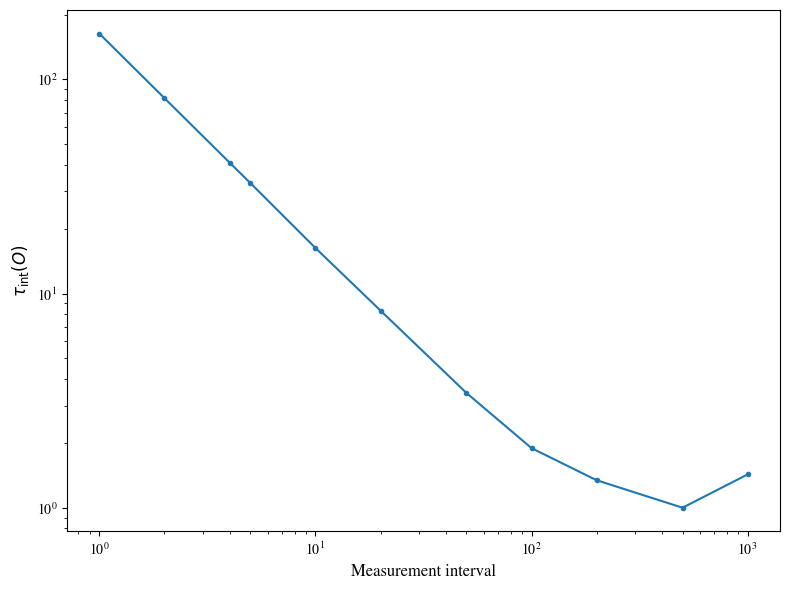

In [42]:
with open("../../u1_2d_obc/config/c_8x8_5.55_sweep1_0.95.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")
V=4
conf=conf[:,:V]

obs = jax.vmap(lambda x: model.observe(x, V))(conf)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000])

test = [autocorr_time_fft(obs[:100000:i]) for i in x_axis]

plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
plt.plot(x_axis, test, marker='.', linestyle='-')#, label='${\\rm err}_{b=1}/{\\rm err}_{b}$')
#plt.plot(x_axis, np.sqrt(x_axis),  label='$\sqrt{x}$')#, marker='.', linestyle='-')
# plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Measurement interval', fontsize=12)
plt.ylabel('$\\tau_{\\rm int}(O)$', fontsize=12)
plt.tight_layout()
# plt.legend(loc='best')
plt.show()

In [43]:
[[i, autocorr_time_fft(obs[:100000:i])] for i in range(100, 400+1, 10)]

[[100, np.float32(1.8973186)],
 [110, np.float32(1.7506533)],
 [120, np.float32(1.7418458)],
 [130, np.float32(1.6024487)],
 [140, np.float32(1.8025694)],
 [150, np.float32(1.4038212)],
 [160, np.float32(1.4995782)],
 [170, np.float32(1.4456079)],
 [180, np.float32(1.4020677)],
 [190, np.float32(1.8990777)],
 [200, np.float32(1.3439159)],
 [210, np.float32(1.2441789)],
 [220, np.float32(1.2557037)],
 [230, np.float32(1.2940793)],
 [240, np.float32(1.3204304)],
 [250, np.float32(1.1366484)],
 [260, np.float32(1.2053549)],
 [270, np.float32(1.0943574)],
 [280, np.float32(1.3911412)],
 [290, np.float32(1.0557206)],
 [300, np.float32(1.0530394)],
 [310, np.float32(1.2982774)],
 [320, np.float32(1.0694085)],
 [330, np.float32(1.037811)],
 [340, np.float32(1.297039)],
 [350, np.float32(1.3374857)],
 [360, np.float32(1.2621205)],
 [370, np.float32(1.0)],
 [380, np.float32(1.3812125)],
 [390, np.float32(1.3933315)],
 [400, np.float32(1.0645838)]]

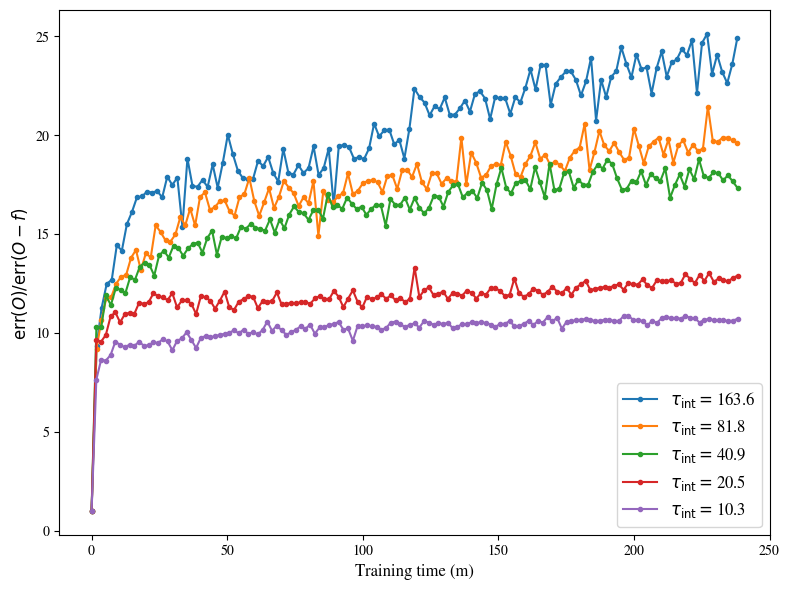

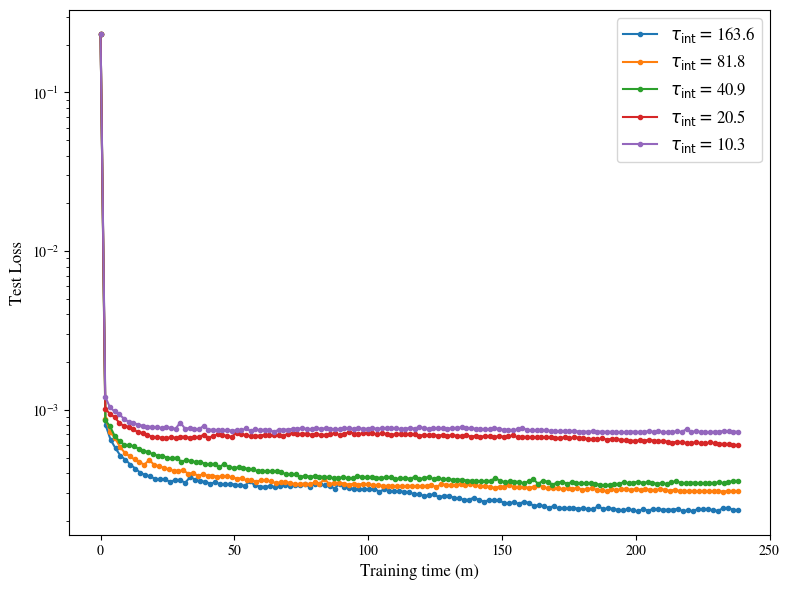

1: 25.124863363171038
2: 21.455245364310127
4: 18.783535335328594
8: 13.322408883186853
16: 10.88950112171693
1: 0.0002289044641656801
2: 0.00030561938183382154
4: 0.00033526733750477433
8: 0.0005982014117762446
16: 0.0007222344866022468


In [46]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("u1_2d_obc/cv_4x1_5.55_new_l3_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_20min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)

autocorr = [autocorr_time_fft(obs[:100000:i]) for i in [1,2,4,8,16]]


plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_red[i]))/len(track_red[i])*240, np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'$\\tau_{{\\rm int}}=${autocorr[i]:.1f}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('${\\rm err}(O) / {\\rm err}(O-f)  $ ', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()


plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_ltest[i]))/len(track_red[i])*240, np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'$\\tau_{{\\rm int}}=${autocorr[i]:.1f}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('Test Loss', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

In [47]:
[[i, autocorr_time_fft(obs[:100000:i])] for i in [250, 400]]

[[250, np.float32(1.1366484)], [400, np.float32(1.0645838)]]

In [73]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [32]*3, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [74]:
binsize=250

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("u1_2d_obc/cv_4x1_5.55_new_l3_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_20min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.23407065868377686 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 25000: <Test loss>: 0.3712643086910248 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.70065427-0.018825065j), np.complex128(0.020641008135547652+0.027726839498651564j)) <f>: (np.float32(-0.008334621), np.complex128(0.02209006940979185+0j))
Epoch 50000: <Test loss>: 0.3605908453464508 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.70023197-0.018825065j), np.complex128(0.02039880374166491+0.027726839498651564j)) <f>: (np.float32(-0.007911793), np.complex128(0.02190622903667327+0j))
Epoch 75000: <Test loss>: 0.3500456213951111 <O>: (np.c

In [87]:
[autocorr_time_fft(obs[:100000:i]) for i in [1,2,4,8,16, 250]]

[np.float32(163.56985),
 np.float32(81.7812),
 np.float32(40.92446),
 np.float32(20.545816),
 np.float32(10.28976),
 np.float32(1.1366484)]

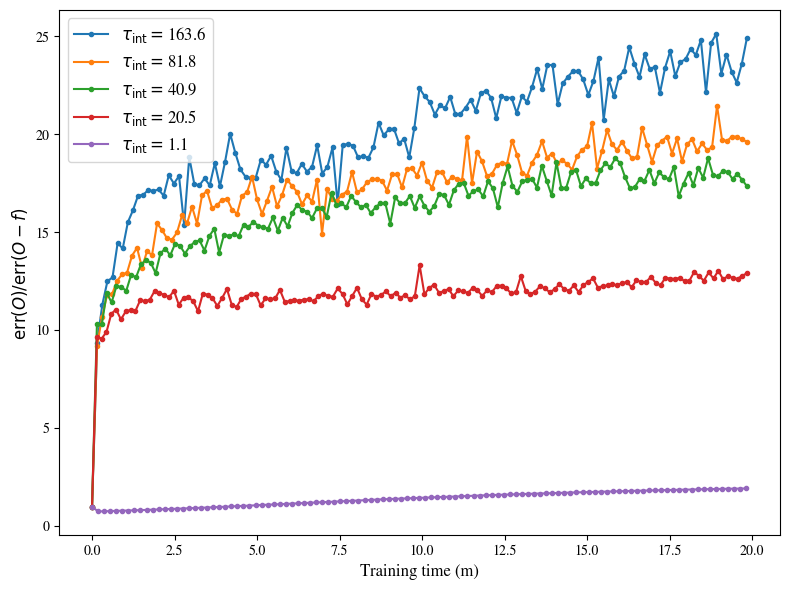

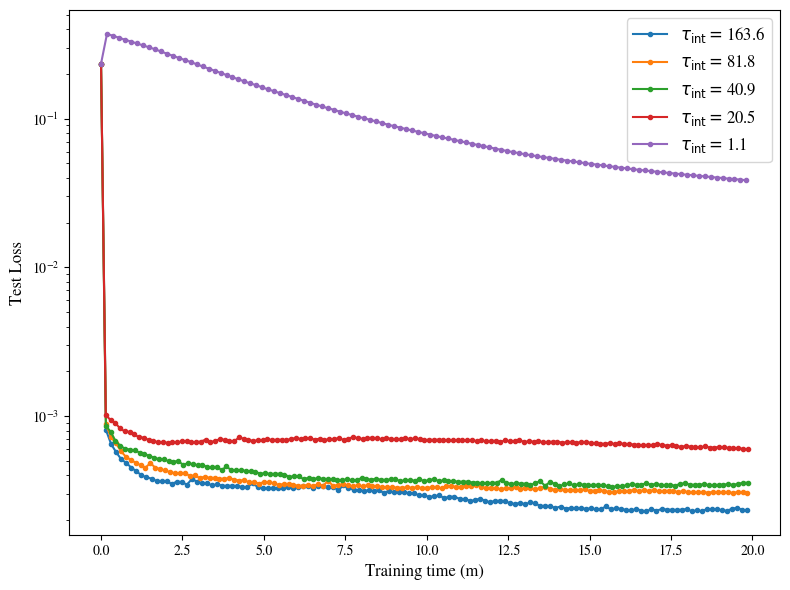

1: 25.124863363171038
2: 21.455245364310127
4: 18.783535335328594
8: 13.322408883186853
16: 1.9310293018515319
1: 0.0002289044641656801
2: 0.00030561938183382154
4: 0.00033526733750477433
8: 0.0005982014117762446
16: 0.03854815289378166


In [50]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8,  250:
    with open("u1_2d_obc/cv_4x1_5.55_new_l3_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_20min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


obs = jax.vmap(lambda x: model.observe(x, V))(conf)
autocorr = [autocorr_time_fft(obs[:100000:i]) for i in [1,2,4,8, 250]]


plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_red[i]))/len(track_red[i])*20, np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'$\\tau_{{\\rm int}}=${autocorr[i]:.1f}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('${\\rm err}(O) / {\\rm err}(O-f)  $ ', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()


plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_ltest[i]))/len(track_red[i])*20, np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'$\\tau_{{\\rm int}}=${autocorr[i]:.1f}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('Test Loss', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

### A=16

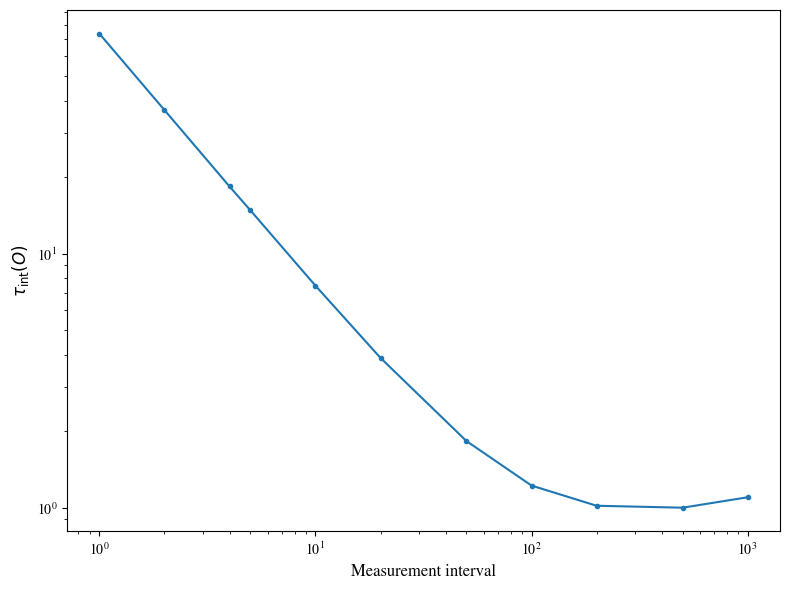

In [52]:
with open("../../u1_2d_obc/config/c_8x8_5.55_sweep1_0.95.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")
V=16
conf=conf[:,:V]

obs = jax.vmap(lambda x: model.observe(x, V))(conf)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000])

test = [autocorr_time_fft(obs[:100000:i]) for i in x_axis]

plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
plt.plot(x_axis, test, marker='.', linestyle='-')#, label='${\\rm err}_{b=1}/{\\rm err}_{b}$')
#plt.plot(x_axis, np.sqrt(x_axis),  label='$\sqrt{x}$')#, marker='.', linestyle='-')
# plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Measurement interval', fontsize=12)
plt.ylabel('$\\tau_{\\rm int}(O)$', fontsize=12)
plt.tight_layout()
# plt.legend(loc='best')
plt.show()

In [78]:
[[i, autocorr_time_fft(obs[:100000:i])] for i in range(50, 200+1, 10)]

[[50, np.float32(1.8301382)],
 [60, np.float32(1.6020849)],
 [70, np.float32(1.4548123)],
 [80, np.float32(1.390309)],
 [90, np.float32(1.2292309)],
 [100, np.float32(1.2223455)],
 [110, np.float32(1.0783156)],
 [120, np.float32(1.225812)],
 [130, np.float32(1.1124063)],
 [140, np.float32(1.1240574)],
 [150, np.float32(1.0)],
 [160, np.float32(1.1052824)],
 [170, np.float32(1.1182445)],
 [180, np.float32(1.1426768)],
 [190, np.float32(1.1433954)],
 [200, np.float32(1.0179433)]]

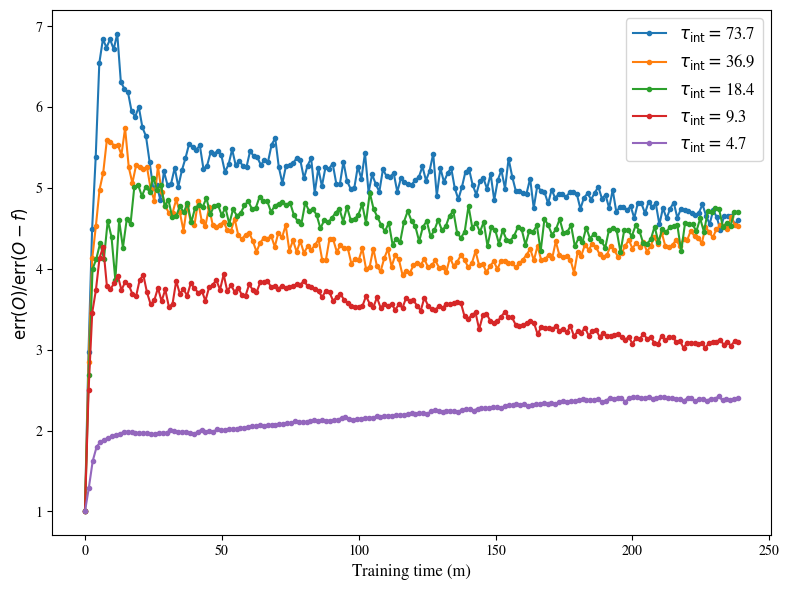

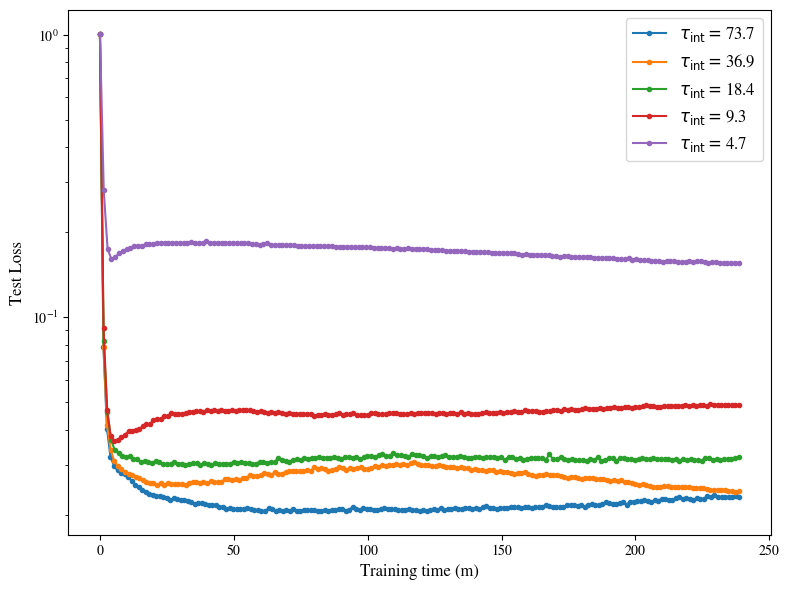

1: 6.906579468502801
2: 5.740324583458335
4: 5.129696798144862
8: 4.27328805661899
16: 2.422392380254361
1: 0.020523278042674065
2: 0.024045681580901146
4: 0.029868612065911293
8: 0.03658305108547211
16: 0.15502721071243286


In [79]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("u1_2d_obc/cv_8x2_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_40min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)

autocorr = [autocorr_time_fft(obs[:100000:i]) for i in [1,2,4,8,16]]


plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_red[i]))/len(track_red[i])*240, np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'$\\tau_{{\\rm int}}=${autocorr[i]:.1f}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('${\\rm err}(O) / {\\rm err}(O-f)  $ ', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()


plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_ltest[i]))/len(track_red[i])*240, np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'$\\tau_{{\\rm int}}=${autocorr[i]:.1f}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('Test Loss', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

In [80]:
[[i, autocorr_time_fft(obs[:100000:i])] for i in [125]]

[[125, np.float32(1.0805125)]]

In [81]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [82]:
binsize=125

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("u1_2d_obc/cv_8x2_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_40min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 1.0069154500961304 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 12500: <Test loss>: 2.0575263500213623 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.309195-0.019788587j), np.complex128(0.06721498926272493+0.03214882239383252j)) <f>: (np.float32(-0.06181823), np.complex128(0.05816832247182075+0j))
Epoch 25000: <Test loss>: 2.0307962894439697 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.3086449-0.019788587j), np.complex128(0.0666591081963496+0.03214882239383252j)) <f>: (np.float32(-0.061268482), np.complex128(0.05758439809631008+0j))
Epoch 37500: <Test loss>: 2.001551628112793 <O>: (np.complex64(0.247

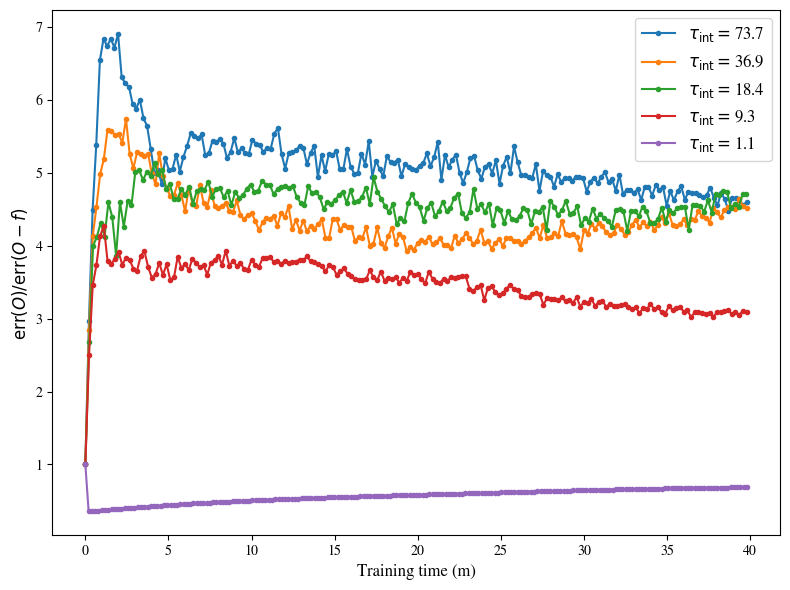

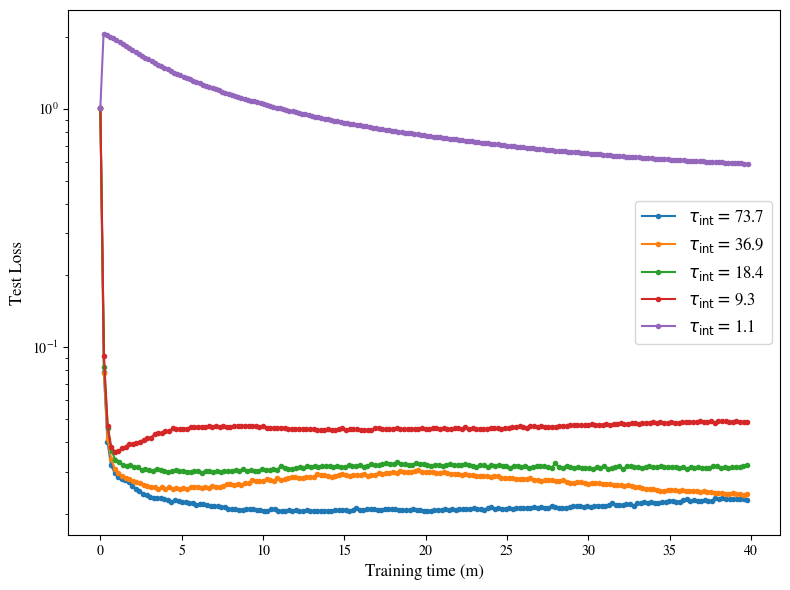

1: 6.906579468502801
2: 5.740324583458335
4: 5.129696798144862
8: 4.27328805661899
16: 1.0
1: 0.020523278042674065
2: 0.024045681580901146
4: 0.029868612065911293
8: 0.03658305108547211
16: 0.5871516466140747


In [53]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8,  125:
    with open("u1_2d_obc/cv_8x2_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_40min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


obs = jax.vmap(lambda x: model.observe(x, V))(conf)
autocorr = [autocorr_time_fft(obs[:100000:i]) for i in [1,2,4,8, 125]]


plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_red[i]))/len(track_red[i])*40, np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'$\\tau_{{\\rm int}}=${autocorr[i]:.1f}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('${\\rm err}(O) / {\\rm err}(O-f)  $ ', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()


plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(5):
    plt.plot(np.arange(len(track_ltest[i]))/len(track_red[i])*40, np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'$\\tau_{{\\rm int}}=${autocorr[i]:.1f}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('Test Loss', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

# Comment 5

In [3]:
from numpy.fft import fft, ifft


def autocorr_time(x, max_lag=None):
    x = np.asarray(x)
    n = len(x)
    x_mean = np.mean(x)
    x = x - x_mean

    var = np.var(x)
    if max_lag is None:
        max_lag = n // 2

    autocorr = np.correlate(x, x, mode='full')[n-1:n+max_lag]
    autocorr /= var * np.arange(n, n - max_lag - 1, -1)
    autocorr /= autocorr[0]  # normalize

    # Find cutoff: when autocorrelation drops below 0
    t = 1
    while t < len(autocorr) - 1 and autocorr[t] > 0:
        t += 1

    tau = 1 + 2 * np.sum(autocorr[1:t])
    return tau


def autocorr_time_fft(x, max_lag=None):
    x = np.asarray(x)
    n = len(x)
    x = x - np.mean(x)
    var = np.var(x, ddof=1)
    if var == 0:
        return 1.0  # or np.nan

    # Next power of 2 for efficient FFT
    n_fft = 2 ** (int(np.ceil(np.log2(2 * n))))
    # print(n_fft)

    # FFT of zero-padded signal
    fx = fft(x, n=n_fft)
    acf = ifft(fx * np.conjugate(fx)).real[:n]

    # Normalize
    acf /= var * np.arange(n, 0, -1)
    acf /= acf[0]

    # Set max lag
    if max_lag is None:
        max_lag = n // 2
    max_lag = min(max_lag, len(acf) - 1)

    # Initial positive sequence
    t = 1
    while t < max_lag and acf[t] > 0:
        t += 1

    tau = 1 + 2 * np.sum(acf[1:t])
    return tau

def autocorr_time_fft_full(x, max_lag=None):
    x = np.asarray(x)
    n = len(x)
    x = x - np.mean(x)
    var = np.var(x, ddof=1)
    if var == 0:
        return 1.0  # or np.nan

    # Next power of 2 for efficient FFT
    n_fft = 2 ** (int(np.ceil(np.log2(2 * n))))
    # print(n_fft)

    # FFT of zero-padded signal
    fx = fft(x, n=n_fft)
    acf = ifft(fx * np.conjugate(fx)).real[:n]

    # Normalize
    acf /= var * np.arange(n, 0, -1)
    acf /= acf[0]

    coef = 1. - np.arange(n)/n

    return 1 + 2 * np.sum(coef*acf)

In [134]:
acf = autocorr_time_fft(obs)[1]
acf[acf>0].sum() + acf[acf<0].sum()

np.float32(-480.78564)

In [4]:
with open("../../1+1scalar/config/c_16x16_0.01_0.1_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("scalar.Model(geom=(16,16), m2=0.01, lamda=0.1)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

jack bin size 1: (np.float32(0.065557405), np.complex128(0.0004388260598136669+0j))
bin size 1: (np.float32(0.065557405), np.complex128(0.0004388045557918774+0j))
jack bin size 2: (np.float32(0.065557405), np.complex128(0.0006181085660653912+0j))
bin size 2: (np.float32(0.065557405), np.complex128(0.0006180990855351279+0j))
jack bin size 4: (np.float32(0.065557405), np.complex128(0.000869248605675147+0j))
bin size 4: (np.float32(0.065557405), np.complex128(0.0008692373835591271+0j))
jack bin size 5: (np.float32(0.065557405), np.complex128(0.0009693441490778686+0j))
bin size 5: (np.float32(0.065557405), np.complex128(0.000969348539370731+0j))
jack bin size 10: (np.float32(0.065557405), np.complex128(0.0013545326766626735+0j))
bin size 10: (np.float32(0.065557405), np.complex128(0.0013545271031914542+0j))
jack bin size 20: (np.float32(0.065557405), np.complex128(0.0018751387205107606+0j))
bin size 20: (np.float32(0.065557405), np.complex128(0.0018751393911356272+0j))
jack bin size 50: (n

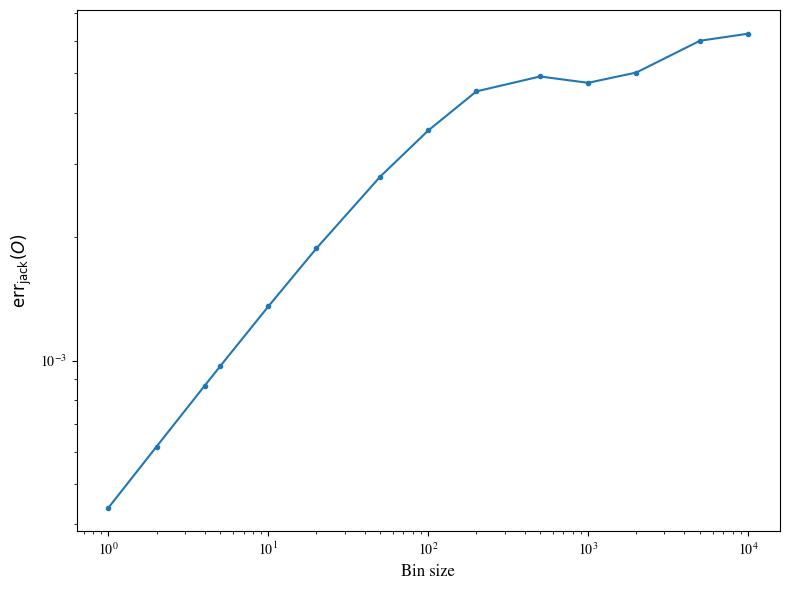

In [6]:
x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
plt.plot(x_axis, np.array(error_jac), marker='.', linestyle='-')#, label='${\\rm err}_{b=1}/{\\rm err}_{b}$')
#plt.plot(x_axis, np.sqrt(x_axis),  label='$\sqrt{x}$')#, marker='.', linestyle='-')
# plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size', fontsize=12)
plt.ylabel('${\\rm err}_{\\rm jack}(O)$', fontsize=12)
plt.tight_layout()
# plt.legend(loc='best')
plt.show()

In [5]:
autocorr_time(obs), autocorr_time_fft(obs), autocorr_time_fft_full(obs)

(np.float32(160.46075), np.float32(160.46074), np.float64(2.0000042209857614))

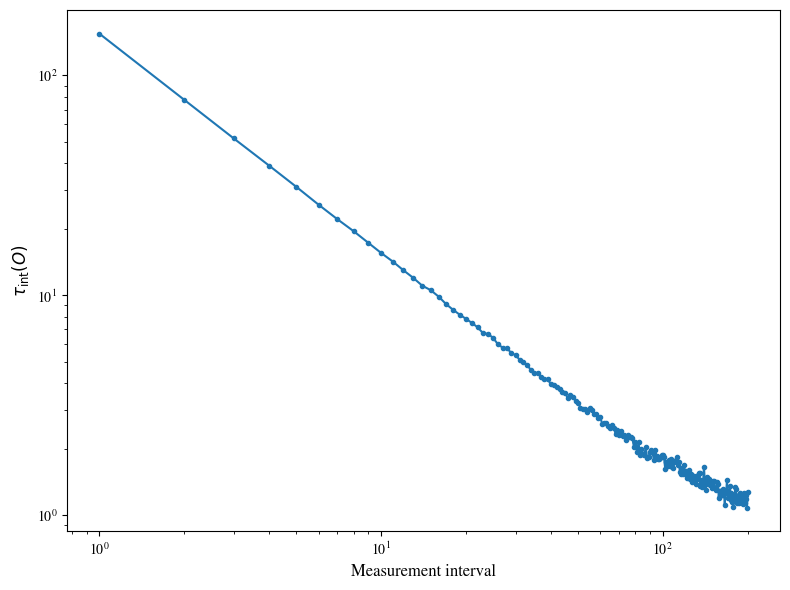

In [7]:
test = [autocorr_time_fft(obs[:100000:i]) for i in range(1,200+1)]

plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
plt.plot(np.arange(1,201), test, marker='.', linestyle='-')#, label='${\\rm err}_{b=1}/{\\rm err}_{b}$')
#plt.plot(x_axis, np.sqrt(x_axis),  label='$\sqrt{x}$')#, marker='.', linestyle='-')
# plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Measurement interval', fontsize=12)
plt.ylabel('$\\tau_{\\rm int}(O)$', fontsize=12)
plt.tight_layout()
# plt.legend(loc='best')
plt.show()

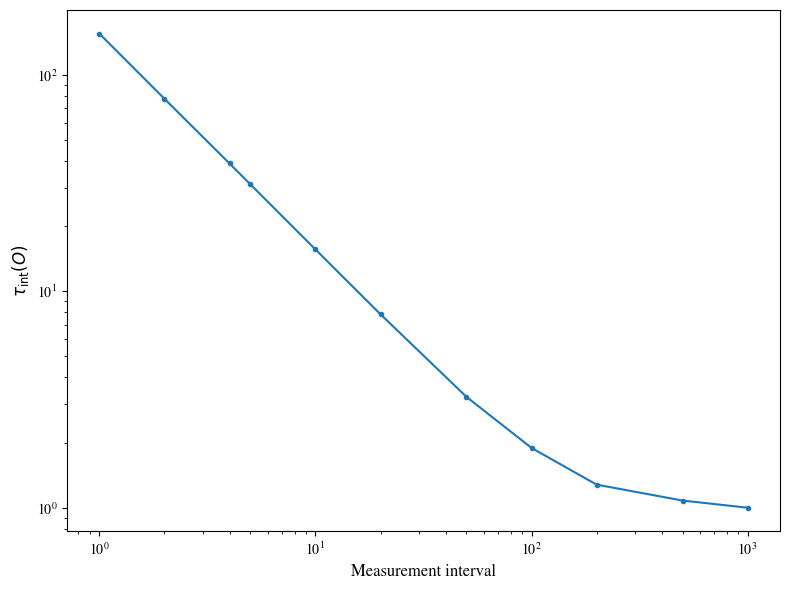

In [8]:
x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000])

test = [autocorr_time_fft(obs[:100000:i]) for i in x_axis]

plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
plt.plot(x_axis, test, marker='.', linestyle='-')#, label='${\\rm err}_{b=1}/{\\rm err}_{b}$')
#plt.plot(x_axis, np.sqrt(x_axis),  label='$\sqrt{x}$')#, marker='.', linestyle='-')
# plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Measurement interval', fontsize=12)
plt.ylabel('$\\tau_{\\rm int}(O)$', fontsize=12)
plt.tight_layout()
# plt.legend(loc='best')
plt.show()

In [9]:
test

[np.float32(154.87086),
 np.float32(77.46701),
 np.float32(38.94524),
 np.float32(31.166483),
 np.float32(15.597034),
 np.float32(7.828073),
 np.float32(3.250558),
 np.float32(1.8887932),
 np.float32(1.27831),
 np.float32(1.0790519),
 np.float32(1.0)]

# Comment 6

In [2]:
class MLP(nn.Module):
    volume: int
    features: Sequence[int]
    kernel_init: Callable = nn.initializers.variance_scaling(
        2, "fan_in", "truncated_normal")  # for ReLU / CELU
    bias_init: Callable = nn.initializers.zeros

    @nn.compact
    def __call__(self, x):
        for feat in self.features:
            x = nn.Dense(feat, use_bias=False,
                         kernel_init=self.kernel_init,
                         bias_init=self.bias_init)(x)
            x = arcsinh(x)
        x = nn.Dense(1, use_bias=False,
                     kernel_init=self.bias_init)(x)
        return x


class CV_MLP(nn.Module):
    volume: int
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = MLP(self.volume, self.features)(x)
        y = self.param('bias', nn.initializers.zeros, (1,))
        return x, y


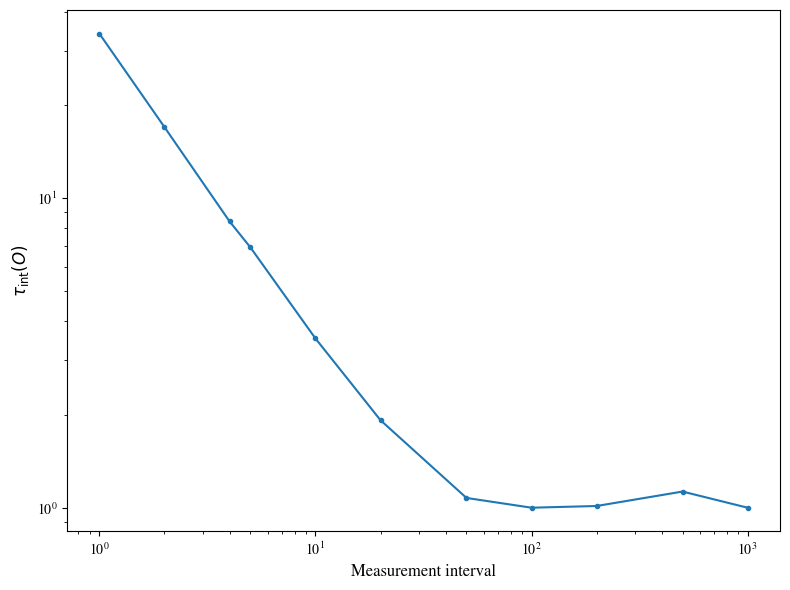

In [4]:
with open("../../1+1scalar/config/c_16x16_0.1_0.5_sweep1.pkl", "rb") as aa:
    conf = pickle.load(aa)


model =  eval("scalar.Model(geom=(16,16), m2=0.1, lamda=0.5)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000])

test = [autocorr_time_fft(obs[:100000:i]) for i in x_axis]

plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
plt.plot(x_axis, test, marker='.', linestyle='-')#, label='${\\rm err}_{b=1}/{\\rm err}_{b}$')
#plt.plot(x_axis, np.sqrt(x_axis),  label='$\sqrt{x}$')#, marker='.', linestyle='-')
# plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Measurement interval', fontsize=12)
plt.ylabel('$\\tau_{\\rm int}(O)$', fontsize=12)
plt.tight_layout()
# plt.legend(loc='best')
plt.show()

In [11]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array(
    [(-i, -j) for i, j in product(*list(map(lambda y: range(y), model.shape)))])


def g(x, p):
    def g_(x, p, ind):
        return g1.apply(p, jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V))[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)

dS = jax.grad(lambda y: model.action(y).real)

dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [12]:
binsize=80

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 64
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("scalar2d/cv_16x16_0.1_0.5_l2_w32_lr1e-4_nt64_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.0016032276907935739 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 8000: <Test loss>: 0.001238895463757217 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0032218315), np.complex128(0.001067792229439689+0j)) <f>: (np.float32(8.8315086e-05), np.complex128(0.0010018812682601511+0j))
Epoch 16000: <Test loss>: 0.0010755134280771017 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0031547765), np.complex128(0.0009929686094544271+0j)) <f>: (np.float32(0.00015537045), np.complex128(0.0009207120148399025+0j))
Epoch 24000: <Test loss>: 0.0009897075360640883 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.003126729), np.complex128(0.0009413971522157449+0j)) <f>: (np.float32(0.00018341783), n

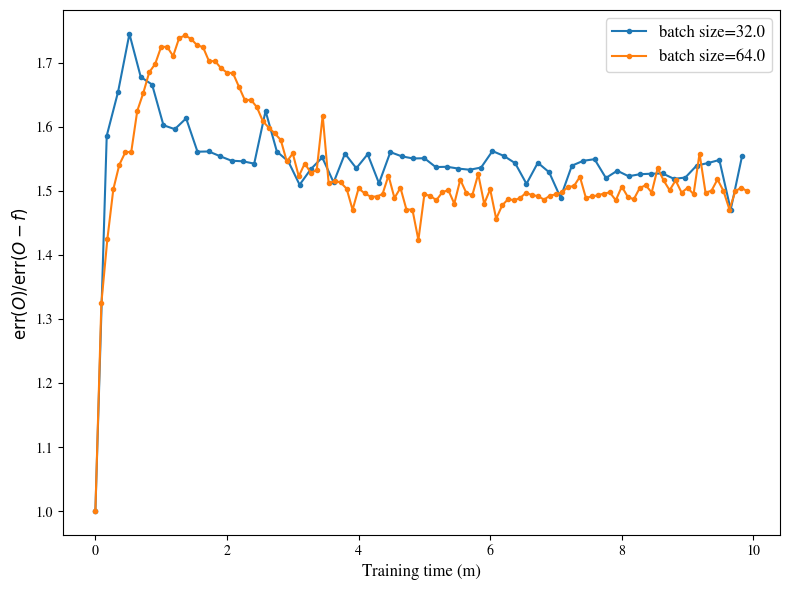

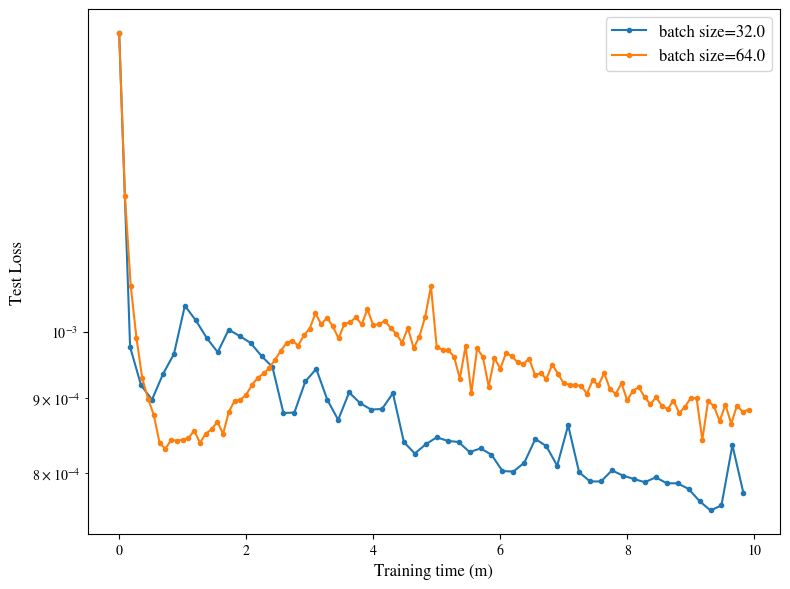

1: (1.7452609233016192+0j)
2: (1.7429215641806366+0j)
1: 0.0007539133657701313
2: 0.0008308103424496949


In [13]:
track_red, track_ltest = [], []

for batchsize in 32, 64:
    with open("scalar2d/cv_16x16_0.1_0.5_l2_w32_lr1e-4_nt"+str(batchsize)+"_ridge0_test1e3_train1e4_sweep1_bs80_10min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)

batchsize = [32, 64]

plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(2):
    plt.plot(np.arange(len(track_red[i]))/len(track_red[i])*10, np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'batch size={batchsize[i]:.1f}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('${\\rm err}(O) / {\\rm err}(O-f)  $ ', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()



plt.figure(figsize=(8,6)).patch.set_facecolor('xkcd:white')
for i in range(2):
    plt.plot(np.arange(len(track_ltest[i]))/len(track_red[i])*10, np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'batch size={batchsize[i]:.1f}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time (m)', fontsize=12)
plt.ylabel('Test Loss', fontsize=12)
plt.tight_layout()
plt.legend(loc='best', fontsize=12)
plt.show()

for i in range(2):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(2):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

In [10]:
10000/80

125.0